# Data Science Project

* Name: Author Name
* Email:


## TABLE OF CONTENTS 


- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.



# OBTAIN

## Imports and Functions

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels
import statsmodels.tsa.api as tsa
import plotly.express as px
import plotly.io as pio
import math
from math import sqrt
import holidays

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


import pickle
import gzip
import shutil
import os

import csv
from pathlib import Path
import subprocess
import io
from icecream import ic
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)



%matplotlib inline

In [2]:
def display_csvfileDF(file_name, folder):
    """This function displays a dataframe from a csv file with all the columns names
    Argument:
    file name: a file a name, str
    folder: a name of a sub-folder in data folder the file is resigning in, str"""
    
    df = pd.read_csv('data/'+folder+file_name, header=0, encoding='UTF-8')
    return df



def empty_string_count(df):
    """Function to count empty strings and null values in na dataframe columns
    Arguments:
    df: a dataframe"""
    clmns_list=df.columns
    for clmn in clmns_list:
        num_empty_strng=len(df[df[clmn]==''])
        num_nulls=len(df[df[clmn].isnull()])
        print('Column {} empty string count: {}'.format(clmn,num_empty_strng))
        print('Column {} null values count: {}'.format(clmn,num_nulls))
        print('******************************************************')
    print('Total number of records in the dataframe: {}'.format(len(df)))
    
def check_stationarity(ts,window,label):
    """This function plots the rolling mean and the rolling standard deviation os a timeseries and prints out
    the results of a Dickey-Fuller test
    Arguments:
    ts: time-series
    window: rolling window, int
    label: a label of the timeseries to be displayed in the legend"""
    
    tsw_sma_mean=ts.rolling(window).mean()
    tsw_sma_std=ts.rolling(window).std()
    
    #Plotting
    fig, ax = plt.subplots(figsize=(18,6))
    sns.set_context('poster')
    sns.set_style('darkgrid')
    sns.set_context('poster')
    sns.set_style('darkgrid')
    ax.plot(ts.index, ts.values, label=label)
    ax.plot(tsw_sma_mean.index,tsw_sma_mean.values, label='Rolling Mean')
    ax.plot(tsw_sma_std.index,tsw_sma_std.values, label='Standard Deviation')
    title='Rolling Mean and Rolling Standard Deviation, '+str(window)+' week window'
    ax.set_title(title, fontsize=28);
    ax.set_ylabel('Offense Counts', fontsize=22);
    ax.set_xlabel('Year', fontsize=22);
    plt.legend(loc='best');
    
    #Dickey-Fuller test results
    stnry_test=adfuller(ts, autolag='AIC')
    t_value=stnry_test[0]
    p_value=stnry_test[1]
    lags=stnry_test[2]
    obsrvns=stnry_test[3]
    critical_values_dict=stnry_test[4]
    print('*********Dickey-Fuller test results*****************\n')
    print('Critival value = {}'.format(t_value))
    print('p-value = {}'.format(p_value))
    print('Number of lags = {}'.format(lags))
    print('Number of observations = {}'.format(obsrvns))
    print('Critical values: \n')
    for key, value in critical_values_dict.items():
        print('Critical value at {}: {}'.format(key, value))
        
def decomposing(ts):
    """Function displays decomposition plots of a times-series in a pretty way
    Arguments:
    ts: time-series"""
    matplotlib.rc_file_defaults()

    decomposition=seasonal_decompose(ts)
    fig=plt.figure()
    fig=decomposition.plot()
    fig.set_size_inches(15,10)
    fig.set_facecolor('lightgrey')
    fig.suptitle('Decomposition Plots', fontsize=20, color='r')
    

## Data

### Data source and data description

Data is from FBI Crime Data Explorer
[NIBRS data for Colorado from 2009-2019](https://crime-data-explorer.fr.cloud.gov/pages/downloads)

The [data dictionary](data/NIBRS_DataDictionary.pdf) is  and a [record descriptiopn](data/NIBRS_Record_Description.pdf) are available.


The description of the main and reference tables is in data/README.md file.
The agency implemented some changes to the files structure in 2016 and removed the sqlite create and load scripts from the zip directories.
Another fact worth mentioning is that files 'nibrs_property_desc.csv' from 2014 and 2015 have duplicated nibrs_property_desc_ids (unique identifier in the nibrs_property_desc table) which complicated the loading of the data.

The rest of the original data description is in description is in the [notebook](capstone_prj_scrub_part1.ipynb) with the first part of data pre-processing.

### Using an already created sqlite database

The notebook with database creation is [here](creating_sqlite_db.ipynb). The referenced database is in ***data/sqlite/db/production1 db***. It takes 2.5 minutes to run the database creation script.

# SCRUB

## Part I, pre-processing the data in SQL database

The first part of the scrubbing process (working with sqlite3 database, production1) is in [this notebook](capstone_prj_scrub_part1.ipynb). It takes about 12 minutes to run the code in part1 notebook. The following code is using dataframes created in part I.

In part I the following dataframes have been created and saved in the pickle files:<br>

    1. df_incident: data/pickled_dataframes/incident.pickle; main incident DF with date/time of an incident
    2. df_offense: data/pickled_dataframes/offense.pickle: main offense DF with offense names and categories
    3. df_offender: data/pickled_dataframes/offender.pickle; main offender DF with demographic info
    4. df_victim: data/pickled_dataframes/victim.pickle; main victim DF with demographic info
    5. df_weapon: data/pickled_dataframes/weapon.pickle; main weapon DF with a weapon category used in an offense
    6. df_bias: data/pickled_dataframes/bias.pickle; main bias DF with offense bias motivation
    7. df_rel: data/pickled_dataframes/relationship.pickle; main victim-offender relationship DF with relationship category
    

## Part II, scrubbing the data in DataFrames

### Using pickle files to create dataframes

In [3]:
with open('data/pickled_dataframes/incident.pickle', 'rb') as f:
    df_incident=pickle.load(f)
df_incident.head()

,agency_id,incident_id,incident_date,incident_hour,primary_county,icpsr_zip
0,1971,51264520,2009-01-05 00:00:00,22,Kit Carson,80807
1,1971,51264521,2009-01-13 00:00:00,25,Kit Carson,80807
2,1971,51264523,2009-01-17 00:00:00,19,Kit Carson,80807
3,1971,51264524,2009-01-20 00:00:00,25,Kit Carson,80807
4,1971,51264525,2009-01-21 00:00:00,25,Kit Carson,80807


In [4]:
len(df_incident)

2819463

In [5]:
with open('data/pickled_dataframes/offense.pickle', 'rb') as f:
    df_offense=pickle.load(f)
df_offense.head()

,offense_id,incident_id,location_name,offense_name,crime_against,offense_category_name
0,53563151,51264520,Residence/Home,Aggravated Assault,Person,Assault Offenses
1,53563402,51264521,Residence/Home,Theft From Motor Vehicle,Property,Larceny/Theft Offenses
2,53558278,51264523,School/College,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses
3,53558279,51264523,School/College,Drug Equipment Violations,Society,Drug/Narcotic Offenses
4,53563403,51264524,Other/Unknown,Impersonation,Property,Fraud Offenses


In [6]:
len(df_offense)

3201143

In [7]:
with open('data/pickled_dataframes/offender.pickle', 'rb') as f:
    df_offender=pickle.load(f)
df_offender.head()

,offender_id,incident_id,age_num,sex_code,race,age_group,ethnicity
0,57702592,51264520,25,Male,White,Age in Years,None
1,57702593,51264521,,,None,None,None
2,57702595,51264523,20,Male,White,Age in Years,None
3,57702596,51264524,,,None,None,None
4,57702597,51264525,55,Male,White,Age in Years,None


In [8]:
len(df_offender)

3197991

In [9]:
with open('data/pickled_dataframes/victim.pickle', 'rb') as f:
    df_victim=pickle.load(f)
df_victim.head()

,victim_id,incident_id,age_num,sex_code,resident_status_code,race,age_group,ethnicity,victim_type
0,55514644,51264520,23,Male,Resident,White,Age in Years,Not Hispanic or Latino,Law Enforcement Officer
1,55514645,51264521,49,Female,Non-resident,White,Age in Years,Unknown,Individual
2,55514647,51264523,,,,None,None,None,Society/Public
3,55514648,51264524,28,Female,Resident,White,Age in Years,Unknown,Individual
4,55514649,51264525,16,Male,Resident,White,Age in Years,Unknown,Individual


In [10]:
len(df_victim)

3229640

In [11]:
with open('data/pickled_dataframes/weapon.pickle', 'rb') as f:
    df_weapon=pickle.load(f)
df_weapon.head()

,offense_id,weapon
0,53563151,Non-automatic firearm
1,53558280,Non-automatic firearm
2,53563153,Non-automatic firearm
3,53579810,Non-automatic firearm
4,53572975,Non-automatic firearm


In [12]:
len(df_weapon)

551049

In [13]:
with open('data/pickled_dataframes/bias.pickle', 'rb') as f:
    df_bias=pickle.load(f)
df_bias.head()

,offense_id,bias_name
0,53563151,None
1,53563402,None
2,53558278,None
3,53558279,None
4,53563403,None


In [14]:
len(df_bias)

3201158

In [15]:
with open('data/pickled_dataframes/relationship.pickle', 'rb') as f:
    df_rel=pickle.load(f)
df_rel.head()

,victim_id,offender_id,relationship_name
0,55514644,57702592,Victim was Otherwise Known
1,55514649,57702597,Victim Was Stepchild
2,55514652,57702601,Victim Was Spouse
3,55514653,57702602,Victim Was Boyfriend/Girlfriend
4,55514655,57702604,Victim Was Child


In [16]:
len(df_rel)

794157

<br><br><span style="font-size:1.2em;">The next step is scrubbing the dataframes in [scrub, part 2 notebook](capstone_prj_scrub_part2.ipynb) </span>

### Checking for duplicates, missing values and other abnormalities, <u>incident table<u>

In [17]:
df_incident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2819463 entries, 0 to 2819462
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   agency_id       int64 
 1   incident_id     int64 
 2   incident_date   object
 3   incident_hour   int64 
 4   primary_county  object
 5   icpsr_zip       object
dtypes: int64(3), object(3)
memory usage: 129.1+ MB


#### Converting incident_date column to a datetime type

In [18]:
df_incident.head()

,agency_id,incident_id,incident_date,incident_hour,primary_county,icpsr_zip
0,1971,51264520,2009-01-05 00:00:00,22,Kit Carson,80807
1,1971,51264521,2009-01-13 00:00:00,25,Kit Carson,80807
2,1971,51264523,2009-01-17 00:00:00,19,Kit Carson,80807
3,1971,51264524,2009-01-20 00:00:00,25,Kit Carson,80807
4,1971,51264525,2009-01-21 00:00:00,25,Kit Carson,80807


In [19]:
df_incident['timestamp']=pd.to_datetime(df_incident.incident_date)
df_incident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2819463 entries, 0 to 2819462
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   agency_id       int64         
 1   incident_id     int64         
 2   incident_date   object        
 3   incident_hour   int64         
 4   primary_county  object        
 5   icpsr_zip       object        
 6   timestamp       datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 150.6+ MB


In [20]:
df_incident.sort_values('timestamp', ascending=True)

,agency_id,incident_id,incident_date,incident_hour,primary_county,icpsr_zip,timestamp
40230,1984,51269326,2009-01-01 00:00:00,12,Larimer,80525,2009-01-01
184495,2119,47560373,2009-01-01 00:00:00,1,Denver,80204,2009-01-01
184494,2119,47560372,2009-01-01 00:00:00,22,Denver,80204,2009-01-01
109516,1831,49921447,2009-01-01 00:00:00,10,Adams,80031,2009-01-01
109514,1831,49942735,2009-01-01 00:00:00,25,Adams,80031,2009-01-01
...,...,...,...,...,...,...,...
2685274,2119,122863693,31-Dec-19,16,Denver,80204,2019-12-31
2807672,2010,119343129,31-Dec-19,21,Moffat,81625,2019-12-31
2719556,1920,120335390,31-Dec-19,21,El Paso,80901,2019-12-31
2583020,2051,120330349,31-Dec-19,23,Pueblo,81003,2019-12-31


#### Checking for duplicates and dropping them

In [21]:
df=df_incident[df_incident.duplicated(subset=['incident_id'],keep=False)].sort_values(by=['incident_id','timestamp'])
df

,agency_id,incident_id,incident_date,incident_hour,primary_county,icpsr_zip,timestamp
1456847,1908,85757101,2015-08-10 00:00:00,17,Douglas,80124,2015-08-10
1733099,1908,85757101,20-Jan-16,22,Douglas,80124,2016-01-20
1456848,1908,85757105,2015-08-10 00:00:00,17,Douglas,80124,2015-08-10
1733102,1908,85757105,19-Jan-16,10,Douglas,80124,2016-01-19
1456849,1908,85757108,2015-08-10 00:00:00,17,Douglas,80124,2015-08-10
...,...,...,...,...,...,...,...
1889452,1920,88326562,1-Nov-16,14,El Paso,80901,2016-11-01
1448247,1893,88338695,2015-05-06 00:00:00,15,Delta,81416,2015-05-06
1830888,1827,88338695,31-Jul-16,7,Arapahoe,80012,2016-07-31
1448388,1893,88339624,2015-12-09 00:00:00,14,Delta,81416,2015-12-09


<br><br><span style="font-size:1.2em;">**There are 548 duplicate incident_id, they seem to be from different dates, counties, zipcodes. Only the first duplicate will be left in the set. The presence of duplicate incident_ids is most probably a human error when the system got switched to another format in 2016.**</span><br><br>


In [22]:
# Dropping rows with duplicate ids and 2016 timestamp (becase their indices are higher). Removing 'incident_date' column.

df_incident=df_incident.drop_duplicates(subset=['incident_id'],keep='last')

In [23]:
df_incident=df_incident.drop(columns=['incident_date'])
df_incident.head()

,agency_id,incident_id,incident_hour,primary_county,icpsr_zip,timestamp
0,1971,51264520,22,Kit Carson,80807,2009-01-05
1,1971,51264521,25,Kit Carson,80807,2009-01-13
2,1971,51264523,19,Kit Carson,80807,2009-01-17
3,1971,51264524,25,Kit Carson,80807,2009-01-20
4,1971,51264525,25,Kit Carson,80807,2009-01-21


#### Checking for empty strings/null values and updating the rows with new values

In [24]:
# Cheching for empty strings and null values
empty_string_count(df_incident)

Column agency_id empty string count: 0
Column agency_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column incident_hour empty string count: 0
Column incident_hour null values count: 0
******************************************************
Column primary_county empty string count: 13771
Column primary_county null values count: 0
******************************************************
Column icpsr_zip empty string count: 2277
Column icpsr_zip null values count: 0
******************************************************
Column timestamp empty string count: 0
Column timestamp null values count: 0
******************************************************
Total number of records in the dataframe: 2819189


<br><br><span style="font-size:1.2em;"> There are no NaN values but ''(empty string) values are present in primary_county and icpsr_zipcode fields</span><br><br>



In [25]:
df=df_incident.loc[df_incident['primary_county']=='']
df.icpsr_zip.unique()

array(['80215'], dtype=object)

<br><br><span style="font-size:1.2em;"> Due to the fact that all primary_county missing values are associated with 80215 zip code, which belongs to Jefferson county. I am filling in these records primary county with 'Jefferson' string.</span><br><br>



In [26]:
df_incident.loc[df_incident.primary_county == '', 'primary_county'] = 'Jefferson'

In [27]:
df=df_incident.loc[df_incident['icpsr_zip']=='']
df.agency_id.unique()

array([ 1982, 23131, 25314], dtype=int64)

<br><br><span style="font-size:1.2em;">**The missing zip codes belong to the following agencies:**</span>
1. agency_id=1982: Fort Lewis College, located in 81301 zip code
2. agency_id=23131: South Metro Drug Task Force, located in 80160 zip code
3. agency_id=25314: Gypsum Police Department, located in 81637 zip code

<br><br><span style="font-size:1.2em;">**The values above will be used to fill in icpsr_zip column values in place of '' values**</span><br><br>



In [28]:
df_incident.loc[((df_incident.icpsr_zip == '')&(df_incident.agency_id==1982)), 'icpsr_zip'] = '81301'

df_incident.loc[((df_incident.icpsr_zip == '')&(df_incident.agency_id==23131)), 'icpsr_zip'] = '80160'

df_incident.loc[((df_incident.icpsr_zip == '')&(df_incident.agency_id==25314)), 'icpsr_zip'] = '81637'

In [29]:
empty_string_count(df_incident)

Column agency_id empty string count: 0
Column agency_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column incident_hour empty string count: 0
Column incident_hour null values count: 0
******************************************************
Column primary_county empty string count: 0
Column primary_county null values count: 0
******************************************************
Column icpsr_zip empty string count: 0
Column icpsr_zip null values count: 0
******************************************************
Column timestamp empty string count: 0
Column timestamp null values count: 0
******************************************************
Total number of records in the dataframe: 2819189


### Checking for duplicates, missing values and other abnormalities, <u>offense table<u>

In [30]:
df_offense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201143 entries, 0 to 3201142
Data columns (total 6 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   offense_id             int64 
 1   incident_id            int64 
 2   location_name          object
 3   offense_name           object
 4   crime_against          object
 5   offense_category_name  object
dtypes: int64(2), object(4)
memory usage: 146.5+ MB


In [31]:
df_offense.head()

,offense_id,incident_id,location_name,offense_name,crime_against,offense_category_name
0,53563151,51264520,Residence/Home,Aggravated Assault,Person,Assault Offenses
1,53563402,51264521,Residence/Home,Theft From Motor Vehicle,Property,Larceny/Theft Offenses
2,53558278,51264523,School/College,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses
3,53558279,51264523,School/College,Drug Equipment Violations,Society,Drug/Narcotic Offenses
4,53563403,51264524,Other/Unknown,Impersonation,Property,Fraud Offenses


#### Checking for duplicates

In [32]:
df=df_offense[df_offense.duplicated(subset=['offense_id'],keep=False)].sort_values(by='offense_id')
df

,offense_id,incident_id,location_name,offense_name,crime_against,offense_category_name


<br><br><span style="font-size:1.2em;"> There are no duplicate offense_ids</span><br><br>



#### Checking for empty strings/null values and updating the rows with new values

In [33]:

empty_string_count(df_offense)

Column offense_id empty string count: 0
Column offense_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column location_name empty string count: 0
Column location_name null values count: 0
******************************************************
Column offense_name empty string count: 0
Column offense_name null values count: 0
******************************************************
Column crime_against empty string count: 0
Column crime_against null values count: 0
******************************************************
Column offense_category_name empty string count: 0
Column offense_category_name null values count: 0
******************************************************
Total number of records in the dataframe: 3201143


<br><br><span style="font-size:1.2em;"> There are no rows with empty strings or NaN values</span><br><br>



###  Checking for duplicates, missing values and other abnormalities, <u>victim table<u>

In [34]:
df_victim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229640 entries, 0 to 3229639
Data columns (total 9 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   victim_id             int64 
 1   incident_id           int64 
 2   age_num               object
 3   sex_code              object
 4   resident_status_code  object
 5   race                  object
 6   age_group             object
 7   ethnicity             object
 8   victim_type           object
dtypes: int64(2), object(7)
memory usage: 221.8+ MB


In [35]:
df_victim.head()

,victim_id,incident_id,age_num,sex_code,resident_status_code,race,age_group,ethnicity,victim_type
0,55514644,51264520,23,Male,Resident,White,Age in Years,Not Hispanic or Latino,Law Enforcement Officer
1,55514645,51264521,49,Female,Non-resident,White,Age in Years,Unknown,Individual
2,55514647,51264523,,,,None,None,None,Society/Public
3,55514648,51264524,28,Female,Resident,White,Age in Years,Unknown,Individual
4,55514649,51264525,16,Male,Resident,White,Age in Years,Unknown,Individual


#### Checking for duplicates

<br><br><span style="font-size:1.2em;">**The same person can be a victim in several incidents therefore we are only checking for duplicates with victim_ids AND incident_ids**</span><br><br>



In [36]:
df=df_victim[df_victim.duplicated(subset=['victim_id','incident_id'],keep=False)].sort_values(by='victim_id')
df

,victim_id,incident_id,age_num,sex_code,resident_status_code,race,age_group,ethnicity,victim_type


<br><br><span style="font-size:1.2em;">No duplicates found</span><br><br>



#### Checking for empty strings/null values

In [37]:
empty_string_count(df_victim)

Column victim_id empty string count: 0
Column victim_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column age_num empty string count: 1032415
Column age_num null values count: 0
******************************************************
Column sex_code empty string count: 991009
Column sex_code null values count: 0
******************************************************
Column resident_status_code empty string count: 1068153
Column resident_status_code null values count: 0
******************************************************
Column race empty string count: 0
Column race null values count: 991009
******************************************************
Column age_group empty string count: 0
Column age_group null values count: 991009
******************************************************
Column ethnicity empty string count: 0


#### Abnormal values, victim table

##### race, NaN values

In [38]:
df=df_victim[df_victim.race.isnull()]
df.victim_type.unique()

array(['Society/Public', 'Business', 'Government', 'Other', 'Unknown',
       'Financial Institution', 'Religious Organization'], dtype=object)

<br><br><span style="font-size:1.2em;">The NAN values in the race column of victims with of types **'Society/Public', 'Business', 'Government', 'Other','Unknown', 'Financial Institution', and 'Religious Organization'** will be replaced with **'NA'** value. Due to the fact that these victim types are the only types of NULL race records, all race NULL values will replaced with 'NA'.</span><br><br>

In [39]:
df_victim.loc[df_victim.race.isnull(), 'race'] = 'NA'

##### ethnicity, NaN values

In [40]:
df=df_victim[df_victim.ethnicity.isnull()]
df.victim_type.unique()

array(['Society/Public', 'Individual', 'Business', 'Government', 'Other',
       'Unknown', 'Financial Institution', 'Religious Organization',
       'Law Enforcement Officer'], dtype=object)

In [41]:
df=df_victim[((df_victim.ethnicity.isnull()) & (df.victim_type.isin(['Law Enforcement Officer', 'Individual'])))]
print('Number of records with empty string in resident_status_code and Individual or \
Law Inforcement victim type: {}'.format(len(df)))
df.head()

Number of records with empty string in resident_status_code and Individual or Law Inforcement victim type: 22210


,victim_id,incident_id,age_num,sex_code,resident_status_code,race,age_group,ethnicity,victim_type
7,55514663,51264539,65,Male,Resident,White,Age in Years,None,Individual
37,55514681,51264550,24,Male,Resident,White,Age in Years,None,Individual
55,55514698,51264566,29,Female,Resident,White,Age in Years,None,Individual
116,54355540,50210712,39,Female,Resident,White,Age in Years,None,Individual
13355,54431861,50279345,43,Male,Resident,Black or African American,Age in Years,None,Individual


<br><br><span style="font-size:1.2em;">1. The NaN values in the ethnicity column of victims with of types **'Society/Public', 'Business', 'Government', 'Other','Unknown', Financial Institution', and 'Religious Organization'** will be replaced with **'NA'** value<br><br>
2. The NaN values in the ethnicity column of victims with of types **'Law Enforcement Officer', 'Individual'** will be replaced with **'Unknown'** value</span><br><br>



In [42]:
df_victim.loc[(df_victim.ethnicity.isnull()
              &df_victim.victim_type.isin(['Society/Public','Business', 'Government','Other','Unknown',
                                            'Financial Institution','Religious Organization'])), 'ethnicity'] = 'NA'

df_victim.loc[(df_victim.ethnicity.isnull()
              &df_victim.victim_type.isin(['Law Enforcement Officer', 'Individual'])), 'ethnicity'] = 'Unknown'

##### age_group, NaN values

In [43]:
df=df_victim[df_victim.age_group.isnull()]
df.victim_type.unique()

array(['Society/Public', 'Business', 'Government', 'Other', 'Unknown',
       'Financial Institution', 'Religious Organization'], dtype=object)

<br><br><span style="font-size:1.2em;">The NAN values in the age_group column of victims with of types **'Society/Public', 'Business', 'Government', 'Other','Unknown', 'Financial Institution', and 'Religious Organization'** will be replaced with **'NA'** value. Due to the fact that these victim types are the only types of NULL age_group records, all age_group NULL will replaced with 'NA'.</span><br><br>



In [44]:
df_victim.loc[df_victim.age_group.isnull(), 'age_group'] = 'NA'

##### age_num, empty string values

In [45]:
df=df_victim[df_victim.age_num=='']
print('Number of records with empty string in age_num: {}'.format(len(df)))
df.victim_type.unique()


Number of records with empty string in age_num: 1032415


array(['Society/Public', 'Business', 'Government', 'Other',
       'Law Enforcement Officer', 'Individual', 'Unknown',
       'Financial Institution', 'Religious Organization'], dtype=object)

In [46]:
df=df_victim[((df_victim.age_num=='') & (df.victim_type.isin(['Law Enforcement Officer', 'Individual'])))]
print('Number of records with empty string in age_num and Individual or Law Inforcement victim type: {}'.format(len(df)))

Number of records with empty string in age_num and Individual or Law Inforcement victim type: 41406


<br><br><span style="font-size:1.2em;">1. The empty string values in the age_num column of victims with types **'Society/Public', 'Business', 'Government', 'Other','Unknown', Financial Institution', and 'Religious Organization'** will be replaced with 999.<br>
2. The empty string values in the age_num column of victims with types **'Law Enforcement Officer', 'Individual'** AND age_group equal 'Unknown' will be replaced with 999.<br>
3. The empty string values in the age_num column of victims with of types **'Law Enforcement Officer', 'Individual'** AND age_group in ('7-364 Days Old','Under 24 Hours','1-6 Days Old') will be replaced with 0.<br>
4. The empty string values in the age_num column of victims with of types **'Law Enforcement Officer', 'Individual'** AND age_group 'Over 98 Years Old' will be replaced with 99.</span>

In [47]:
df_victim.loc[((df_victim.age_num=='')
              &df_victim.victim_type.isin(['Society/Public','Business', 'Government','Other','Unknown',
                                            'Financial Institution','Religious Organization'])), 'age_num'] = '999'
df_victim.loc[((df_victim.age_num=='')
              &(df_victim.victim_type.isin(['Law Enforcement Officer', 'Individual']))
              &(df_victim.age_group.isin(['7-364 Days Old','Under 24 Hours','1-6 Days Old']))), 'age_num'] = '0'

df_victim.loc[((df_victim.age_num=='')
              &(df_victim.victim_type.isin(['Law Enforcement Officer', 'Individual']))
              &(df_victim.age_group=='Over 98 Years Old')), 'age_num'] = '99'

df_victim.loc[((df_victim.age_num=='')
              &(df_victim.victim_type.isin(['Law Enforcement Officer', 'Individual']))
              &(df_victim.age_group=='Unknown')), 'age_num'] = '999'

##### sex_code, empty string values

In [48]:
df=df_victim[df_victim.sex_code=='']
print('Number of records with empty string in sex_code: {}'.format(len(df)))
df.victim_type.unique()

Number of records with empty string in sex_code: 991009


array(['Society/Public', 'Business', 'Government', 'Other', 'Unknown',
       'Financial Institution', 'Religious Organization'], dtype=object)

<br><br><span style="font-size:1.2em;">The empty string values in the sex_code column of victims with of types **'Society/Public', 'Business', 'Government', 'Other','Unknown', Financial Institution', and 'Religious Organization'** will be replaced with **'NA'** value. Due to the fact that these victim types are the only types of sex_code empty string records, all sex_code empty string values will replaced with **'NA'**.</span><br>



In [49]:
df_victim.loc[df_victim.sex_code=='', 'sex_code'] = 'NA'

##### resident_status_code, empty string values

In [50]:
df=df_victim[df_victim.resident_status_code=='']
print('Number of records with empty string in resident_status_code: {}'.format(len(df)))
df.victim_type.unique()

Number of records with empty string in resident_status_code: 1068153


array(['Society/Public', 'Business', 'Government', 'Other', 'Unknown',
       'Financial Institution', 'Religious Organization', 'Individual',
       'Law Enforcement Officer'], dtype=object)

In [51]:
df=df_victim[((df_victim.resident_status_code=='') & (df.victim_type.isin(['Law Enforcement Officer', 'Individual'])))]
print('Number of records with empty string in resident_status_code and Individual or \
Law Inforcement victim type: {}'.format(len(df)))

Number of records with empty string in resident_status_code and Individual or Law Inforcement victim type: 77144


<br><br><span style="font-size:1.2em;">1. The empty string values in the resident_status_code column of victims with of types **'Society/Public', 'Business', 'Government', 'Other','Unknown', Financial Institution', and 'Religious Organization'** will be replaced with **'NA'** value<br><br>
2. The empty string values in the resident_status_code column of victims with of types **'Law Enforcement Officer', 'Individual'** will be replaced with **'Unknown'** value</span><br><br>



In [52]:
df_victim.loc[((df_victim.resident_status_code=='')
              &df_victim.victim_type.isin(['Society/Public','Business', 'Government','Other',
                                           'Unknown','Financial Institution',
                                           'Religious Organization'])), 'resident_status_code'] = 'NA'

df_victim.loc[((df_victim.resident_status_code=='')
              &(df_victim.victim_type.isin(['Law Enforcement Officer',
                                            'Individual']))), 'resident_status_code'] = 'Unknown'

##### Renaming the columns

In [53]:
df_victim=df_victim.rename(columns={'age_num': 'victim_age', 'sex_code': 'victim_sex',
                          'resident_status_code': 'victim_resident_status','race': 'victim_race',
                         'age_group':'victim_age_group','ethnicity':'victim_ethnicity'})

In [54]:
empty_string_count(df_victim)

Column victim_id empty string count: 0
Column victim_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column victim_age empty string count: 0
Column victim_age null values count: 0
******************************************************
Column victim_sex empty string count: 0
Column victim_sex null values count: 0
******************************************************
Column victim_resident_status empty string count: 0
Column victim_resident_status null values count: 0
******************************************************
Column victim_race empty string count: 0
Column victim_race null values count: 0
******************************************************
Column victim_age_group empty string count: 0
Column victim_age_group null values count: 0
******************************************************
Column victim_ethnicity 

###  Checking for duplicates, missing values and other abnormalities, <u>offender table<u>

In [55]:
df_offender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197991 entries, 0 to 3197990
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   offender_id  int64 
 1   incident_id  int64 
 2   age_num      object
 3   sex_code     object
 4   race         object
 5   age_group    object
 6   ethnicity    object
dtypes: int64(2), object(5)
memory usage: 170.8+ MB


In [56]:
df_offender.head()

,offender_id,incident_id,age_num,sex_code,race,age_group,ethnicity
0,57702592,51264520,25,Male,White,Age in Years,None
1,57702593,51264521,,,None,None,None
2,57702595,51264523,20,Male,White,Age in Years,None
3,57702596,51264524,,,None,None,None
4,57702597,51264525,55,Male,White,Age in Years,None


#### Checking for duplicates

**The same person can be an offender in several incidents therefore we are only checking for duplicates with offender_ids AND incident_ids**

In [57]:
df=df_offender[df_offender.duplicated(subset=['offender_id', 'incident_id'],keep=False)].sort_values(by='offender_id')
df

,offender_id,incident_id,age_num,sex_code,race,age_group,ethnicity


<br><br><span style="font-size:1.2em;"> No duplicates found</span><br><br>



#### Checking for empty strings/null values

In [58]:
empty_string_count(df_offender)

Column offender_id empty string count: 0
Column offender_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column age_num empty string count: 1509300
Column age_num null values count: 0
******************************************************
Column sex_code empty string count: 912428
Column sex_code null values count: 0
******************************************************
Column race empty string count: 0
Column race null values count: 912428
******************************************************
Column age_group empty string count: 0
Column age_group null values count: 912428
******************************************************
Column ethnicity empty string count: 0
Column ethnicity null values count: 1972733
******************************************************
Total number of records in the dataframe: 3197991


#### Abnormal values, offender table

##### ethnicity, NaN values

In [59]:
print('Number of records with NaN values in ethnicity: {}'.format(df_offender['ethnicity'].isnull().sum()))
df_offender['ethnicity'].value_counts()

Number of records with NaN values in ethnicity: 1972733


Not Hispanic or Latino    577692
Unknown                   434094
Hispanic or Latino        213472
Name: ethnicity, dtype: int64

<br><br><span style="font-size:1.2em;">The NaN value in the **ethnicity** column of offender table will be replaced with **'Unknown'** value</span><br>



In [60]:
df_offender.loc[df_offender.ethnicity.isnull(), 'ethnicity'] = 'Unknown'

##### race, NaN values

In [61]:
print('Number of records with NaN values in race: {}'.format(df_offender['race'].isnull().sum()))
df_offender['race'].value_counts()

Number of records with NaN values in race: 912428


White                                                1438051
Unknown                                               549611
Black or African American                             270218
Asian                                                  11110
American Indian or Alaska Native                       10566
Asian, Native Hawaiian, or Other Pacific Islander       5175
Native Hawaiian or Other Pacific Islander                832
Name: race, dtype: int64

<br><br><span style="font-size:1.2em;">The NaN value in the **race** column of offender table will be replaced with **Unknown** value</span><br><br>



In [62]:
df_offender.loc[df_offender.race.isnull(), 'race'] = 'Unknown'

##### age_group, NaN values

In [63]:
print('Number of records with NaN values in age_group: {}'.format(df_offender['age_group'].isnull().sum()))
df_offender['age_group'].value_counts()

Number of records with NaN values in age_group: 912428


Age in Years         1688691
Unknown               596172
Over 98 Years Old        700
Name: age_group, dtype: int64

In [64]:
df_offender.loc[df_offender['age_group'].isnull()]

,offender_id,incident_id,age_num,sex_code,race,age_group,ethnicity
1,57702593,51264521,,,Unknown,None,Unknown
3,57702596,51264524,,,Unknown,None,Unknown
7,57702612,51264539,,,Unknown,None,Unknown
11,57702603,51264530,,,Unknown,None,Unknown
13,57702605,51264532,,,Unknown,None,Unknown
...,...,...,...,...,...,...,...
3197957,133652222,117657878,,,Unknown,None,Unknown
3197970,133657157,117657929,,,Unknown,None,Unknown
3197974,133652341,117648019,,,Unknown,None,Unknown
3197980,133652400,117658019,,,Unknown,None,Unknown


<br><br><span style="font-size:1.2em;">The NaN value in the **age_group** column of offender table will be replaced with **Unknown** value. Spot checking the records did not generate any insights. All those offenders are simply not known, never got identified.</span><br><br>



In [65]:
df_offender.loc[df_offender.age_group.isnull(), 'age_group'] = 'Unknown'

##### age_num, empty string values

In [66]:
df=df_offender[df_offender.age_num=='']
print('Number of records with empty string in age_num: {}'.format(len(df)))
print('Number of records with NaN values in age_group: {}'.format(df['age_group'].isnull().sum()))
df['age_group'].value_counts()

Number of records with empty string in age_num: 1509300
Number of records with NaN values in age_group: 0


Unknown              1508600
Over 98 Years Old        700
Name: age_group, dtype: int64

<br><br><span style="font-size:1.2em;">1. The empty string in the **age_num** of offender table with age_group values equal **'Over 98 Years Old'** will be replaced with **99** value<br>
2. The empty string in the **age_num** of offender table with age_group values equal **'Unknown'** will be replaced with **999** value</span><br>

In [67]:
df_offender.loc[((df_offender.age_num=='')&(df_offender.age_group=='Over 98 Years Old')), 'age_num'] = '99'

df_offender.loc[((df_offender.age_num=='')
                 &(df_offender.age_group=='Unknown')), 'age_num'] = '999'

##### sex_code, empty string values

In [68]:
df_offender['sex_code'].value_counts()

Male       1325988
            912428
Female      501641
Unknown     457934
Name: sex_code, dtype: int64

<br><br><span style="font-size:1.2em;">The empty string value in the **sex_code** column of offender table will be replaced with **'Unknown'** value</span><br>

In [69]:
df_offender.loc[df_offender.sex_code=='', 'sex_code'] = 'Unknown'

##### Renaming the columns

In [70]:
df_offender=df_offender.rename(columns={'age_num': 'offender_age', 'sex_code': 'offender_sex',
                                        'race': 'offender_race', 'age_group':'offender_age_group',
                                        'ethnicity':'offender_ethnicity'})

In [71]:
empty_string_count(df_offender)

Column offender_id empty string count: 0
Column offender_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column offender_age empty string count: 0
Column offender_age null values count: 0
******************************************************
Column offender_sex empty string count: 0
Column offender_sex null values count: 0
******************************************************
Column offender_race empty string count: 0
Column offender_race null values count: 0
******************************************************
Column offender_age_group empty string count: 0
Column offender_age_group null values count: 0
******************************************************
Column offender_ethnicity empty string count: 0
Column offender_ethnicity null values count: 0
******************************************************
Total number

### Checking for duplicates, missing values and other abnormalities, <u>weapon table<u>

In [72]:
df_weapon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551049 entries, 0 to 551048
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   offense_id  551049 non-null  int64 
 1   weapon      551049 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


In [73]:
empty_string_count(df_weapon)

Column offense_id empty string count: 0
Column offense_id null values count: 0
******************************************************
Column weapon empty string count: 0
Column weapon null values count: 0
******************************************************
Total number of records in the dataframe: 551049


In [74]:
# Checking for duplicates in offense_id column
df=df_weapon[df_weapon.duplicated(subset=['offense_id'],keep=False)].sort_values(by='offense_id')
df

,offense_id,weapon
14148,51643793,Non-automatic firearm
14149,51643793,Other weapon
14002,51646792,Other weapon
14003,51646792,Other weapon
13978,51646830,Non-automatic firearm
...,...,...
528537,148659366,Non-automatic firearm
528538,148659366,Other weapon
528539,148659366,Other weapon
528614,148660117,Other weapon


<br><br><span style="font-size:1.2em;">There can be several types of weapons used in one offense. For the sake of simplicity I will drop duplicates from the table.</span><br><br>

In [75]:
df_weapon=df_weapon.drop_duplicates(subset=['offense_id'],keep='last')

### Checking for duplicates, missing values and other abnormalities, <u>bias table<u>

In [76]:
df_bias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201158 entries, 0 to 3201157
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   offense_id  int64 
 1   bias_name   object
dtypes: int64(1), object(1)
memory usage: 48.8+ MB


In [77]:
empty_string_count(df_bias)

Column offense_id empty string count: 0
Column offense_id null values count: 0
******************************************************
Column bias_name empty string count: 0
Column bias_name null values count: 0
******************************************************
Total number of records in the dataframe: 3201158


In [78]:
# Checking for duplicates in offense_id column
df=df_bias[df_bias.duplicated(subset=['offense_id'],keep=False)].sort_values(by='offense_id')
df

,offense_id,bias_name
2060439,111048055,Anti-White
2060440,111048055,Anti-Jewish
1926231,111048057,Anti-White
1926232,111048057,Anti-Jewish
1916086,111048061,Anti-White
1916087,111048061,Anti-Jewish
2060448,111048070,Anti-Hispanic or Latino
2060447,111048070,Anti-Multi-Racial Group
2060446,111048070,Anti-Black or African American
2060445,111048070,Anti-White


<br><br><span style="font-size:1.2em;"> There can be several types of biases in one offense. The number of duplicates is low. For the sake of simplicity I will drop duplicates from the table.</span><br><br>



In [79]:
df_bias=df_bias.drop_duplicates(subset=['offense_id'],keep='last')

### Checking for duplicates, missing values and other abnormalities, <u>relationship table<u>

In [80]:
df_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794157 entries, 0 to 794156
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   victim_id          794157 non-null  int64 
 1   offender_id        794157 non-null  int64 
 2   relationship_name  791868 non-null  object
dtypes: int64(2), object(1)
memory usage: 18.2+ MB


In [81]:
empty_string_count(df_rel)

Column victim_id empty string count: 0
Column victim_id null values count: 0
******************************************************
Column offender_id empty string count: 0
Column offender_id null values count: 0
******************************************************
Column relationship_name empty string count: 0
Column relationship_name null values count: 2289
******************************************************
Total number of records in the dataframe: 794157


In [82]:
df_rel['relationship_name'].value_counts()

Victim Was Stranger                            168712
Relationship Unknown                           133504
Victim Was Boyfriend/Girlfriend                101800
Victim Was Acquaintance                         92034
Victim was Otherwise Known                      77439
Victim Was Spouse                               48593
Victim Was Offender                             29886
Victim Was Child                                24853
Victim Was Friend                               19718
Victim Was Parent                               16199
Victim Was Other Family Member                  13803
Victim Was Sibling                              13440
Victim Was Neighbor                              9883
Victim was Ex-Spouse                             8359
Victim Was Common-Law Spouse                     8189
Homosexual Relationship                          4639
Victim Was Stepchild                             4326
Victim Was Child of Boyfriend or Girlfriend      3281
Victim Was In-law           

In [83]:
# Replacing NULL values in relationship_name to 'Relationship Unknown'
df_rel.loc[df_rel.relationship_name.isnull(), 'relationship_name'] = 'Relationship Unknown'

In [84]:
# Checking for duplicates in offense_id column
df=df_rel[df_rel.duplicated(subset=['victim_id','offender_id'],keep=False)].sort_values(by='victim_id')
df

,victim_id,offender_id,relationship_name


## Part III, combining the DataFrames

### DFs Info

In [85]:
df_incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2819189 entries, 0 to 2819462
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   agency_id       int64         
 1   incident_id     int64         
 2   incident_hour   int64         
 3   primary_county  object        
 4   icpsr_zip       object        
 5   timestamp       datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 150.6+ MB


In [86]:
df_offense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201143 entries, 0 to 3201142
Data columns (total 6 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   offense_id             int64 
 1   incident_id            int64 
 2   location_name          object
 3   offense_name           object
 4   crime_against          object
 5   offense_category_name  object
dtypes: int64(2), object(4)
memory usage: 146.5+ MB


In [87]:
df_offender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197991 entries, 0 to 3197990
Data columns (total 7 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   offender_id         int64 
 1   incident_id         int64 
 2   offender_age        object
 3   offender_sex        object
 4   offender_race       object
 5   offender_age_group  object
 6   offender_ethnicity  object
dtypes: int64(2), object(5)
memory usage: 170.8+ MB


In [88]:
df_victim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229640 entries, 0 to 3229639
Data columns (total 9 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   victim_id               int64 
 1   incident_id             int64 
 2   victim_age              object
 3   victim_sex              object
 4   victim_resident_status  object
 5   victim_race             object
 6   victim_age_group        object
 7   victim_ethnicity        object
 8   victim_type             object
dtypes: int64(2), object(7)
memory usage: 221.8+ MB


In [89]:
df_weapon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540940 entries, 0 to 551048
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   offense_id  540940 non-null  int64 
 1   weapon      540940 non-null  object
dtypes: int64(1), object(1)
memory usage: 12.4+ MB


In [90]:
df_weapon.weapon.value_counts()

Non-automatic firearm    420917
Other weapon             104428
Unknown                   10189
Unarmed                    2803
Automatic firearm          2603
Name: weapon, dtype: int64

In [91]:
df_bias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201143 entries, 0 to 3201157
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   offense_id  int64 
 1   bias_name   object
dtypes: int64(1), object(1)
memory usage: 73.3+ MB


In [92]:
df_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794157 entries, 0 to 794156
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   victim_id          794157 non-null  int64 
 1   offender_id        794157 non-null  int64 
 2   relationship_name  794157 non-null  object
dtypes: int64(2), object(1)
memory usage: 18.2+ MB


<br><br><span style="font-size:1.2em;"><b>1. Offense, incident, bias and weapon DataFrames will be combined into one for the Times-series analysis<br>
2. Offender, victim and relationship DataFrames will be set aside for the dashboard.</b></span><br><br>

### Combining Incident, Offense, Bias and Weapon DataFrames

In [93]:
df_full=df_offense.merge(df_incident, how='left', on='incident_id')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201143 entries, 0 to 3201142
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   offense_id             int64         
 1   incident_id            int64         
 2   location_name          object        
 3   offense_name           object        
 4   crime_against          object        
 5   offense_category_name  object        
 6   agency_id              int64         
 7   incident_hour          int64         
 8   primary_county         object        
 9   icpsr_zip              object        
 10  timestamp              datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 293.1+ MB


In [94]:
df_full=df_full.merge(df_bias, how='left', on='offense_id')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201143 entries, 0 to 3201142
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   offense_id             int64         
 1   incident_id            int64         
 2   location_name          object        
 3   offense_name           object        
 4   crime_against          object        
 5   offense_category_name  object        
 6   agency_id              int64         
 7   incident_hour          int64         
 8   primary_county         object        
 9   icpsr_zip              object        
 10  timestamp              datetime64[ns]
 11  bias_name              object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 317.5+ MB


In [95]:
df_full=df_full.merge(df_weapon, how='left', on='offense_id')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201143 entries, 0 to 3201142
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   offense_id             int64         
 1   incident_id            int64         
 2   location_name          object        
 3   offense_name           object        
 4   crime_against          object        
 5   offense_category_name  object        
 6   agency_id              int64         
 7   incident_hour          int64         
 8   primary_county         object        
 9   icpsr_zip              object        
 10  timestamp              datetime64[ns]
 11  bias_name              object        
 12  weapon                 object        
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 341.9+ MB


In [96]:
empty_string_count(df_full)

Column offense_id empty string count: 0
Column offense_id null values count: 0
******************************************************
Column incident_id empty string count: 0
Column incident_id null values count: 0
******************************************************
Column location_name empty string count: 0
Column location_name null values count: 0
******************************************************
Column offense_name empty string count: 0
Column offense_name null values count: 0
******************************************************
Column crime_against empty string count: 0
Column crime_against null values count: 0
******************************************************
Column offense_category_name empty string count: 0
Column offense_category_name null values count: 0
******************************************************
Column agency_id empty string count: 0
Column agency_id null values count: 0
******************************************************
Column incident_hour emp

In [97]:
df_full.weapon.unique()

array(['Non-automatic firearm', nan, 'Other weapon', 'Unknown', 'Unarmed',
       'Automatic firearm'], dtype=object)

In [98]:
df=df_full[df_full.weapon.isnull()]
df.offense_category_name.unique()

array(['Larceny/Theft Offenses', 'Drug/Narcotic Offenses',
       'Fraud Offenses', 'Destruction/Damage/Vandalism of Property',
       'Burglary/Breaking & Entering', 'Assault Offenses', 'Sex Offenses',
       'Arson', 'Motor Vehicle Theft', 'Pornography/Obscene Material',
       'Counterfeiting/Forgery', 'Bribery', 'Stolen Property Offenses',
       'Prostitution Offenses', 'Embezzlement', 'Gambling Offenses',
       'Animal Cruelty'], dtype=object)

In [99]:
# Replacing NaN values in weapon column by 'NA'. Offenses associated with weapon NaN values seem
# to be offenses with no weapon necessary

df_full.loc[df_full.weapon.isnull(), 'weapon'] = 'NA'

# EXPLORE

## EDA

### General information about the data

In [100]:
print('There are {} records of offenses in Colorado between 2009 and 2019'.format(len(df_full)))

There are 3201143 records of offenses in Colorado between 2009 and 2019


In [101]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201143 entries, 0 to 3201142
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   offense_id             int64         
 1   incident_id            int64         
 2   location_name          object        
 3   offense_name           object        
 4   crime_against          object        
 5   offense_category_name  object        
 6   agency_id              int64         
 7   incident_hour          int64         
 8   primary_county         object        
 9   icpsr_zip              object        
 10  timestamp              datetime64[ns]
 11  bias_name              object        
 12  weapon                 object        
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 341.9+ MB


In [102]:
df_full.nunique()

offense_id               3201143
incident_id              2819189
location_name                 46
offense_name                  51
crime_against                  4
offense_category_name         23
agency_id                    249
incident_hour                 25
primary_county                64
icpsr_zip                    195
timestamp                   4017
bias_name                     30
weapon                         6
dtype: int64

<ipython-input-103-7c6c3b1d3001>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


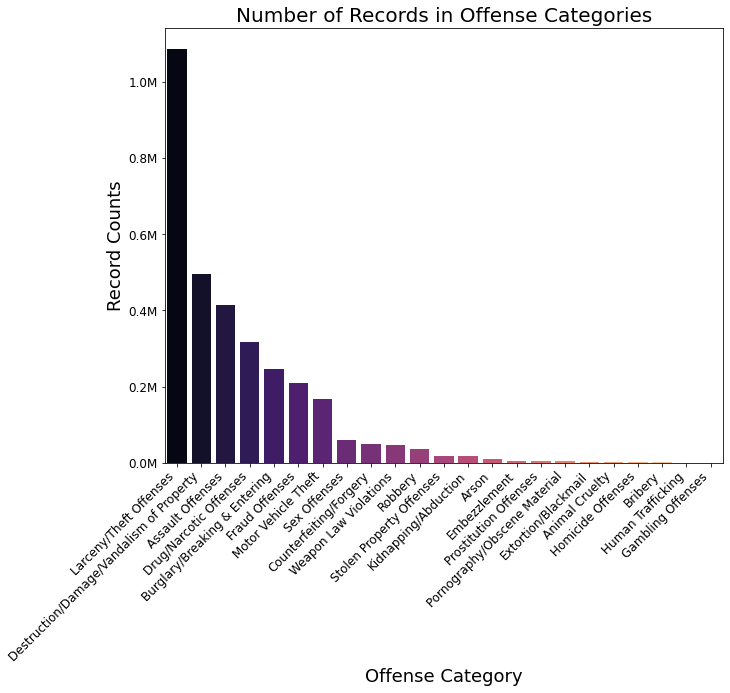

In [103]:
fig, ax = plt.subplots(figsize=(10,8))
g=sns.countplot(x='offense_category_name', data=df_full, ax=ax, palette='magma',
              order=df_full.offense_category_name.value_counts().index)
ax.set_title('Number of Records in Offense Categories', fontsize=20);
ax.set_ylabel('Record Counts', fontsize=18);
ax.set_xlabel('Offense Category', fontsize=18);
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right',fontsize=12)
ax.set_yticklabels(ylabels)
ax.tick_params(labelsize=12)

In [104]:
# fig = px.bar(df_full, x='offense_category_name', y=df_full.offense_id.value_counts().index, height=400)
# fig.show()

<ipython-input-105-4a5918f84457>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


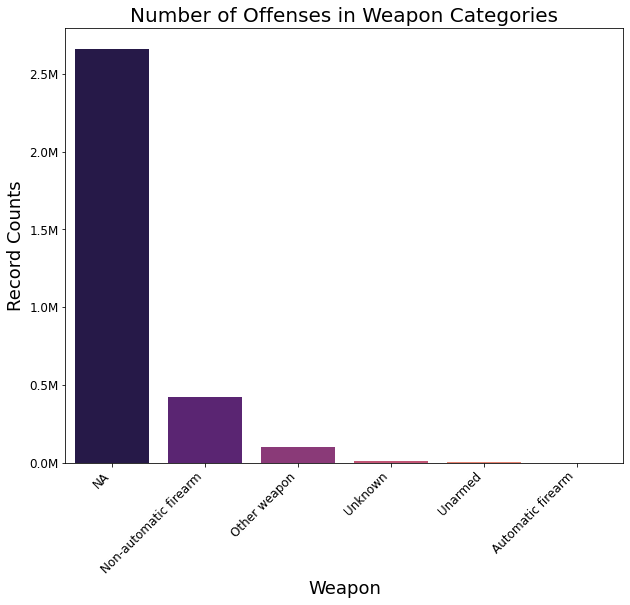

In [105]:
fig, ax = plt.subplots(figsize=(10,8))
g=sns.countplot(x='weapon', data=df_full, ax=ax, palette='magma',
              order=df_full.weapon.value_counts().index)
ax.set_title('Number of Offenses in Weapon Categories', fontsize=20);
ax.set_ylabel('Record Counts', fontsize=18);
ax.set_xlabel('Weapon', fontsize=18);
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right',fontsize=12)
ax.set_yticklabels(ylabels)
ax.tick_params(labelsize=12)

Text(0.5, 1.0, 'Zip codes with Most Offenses')

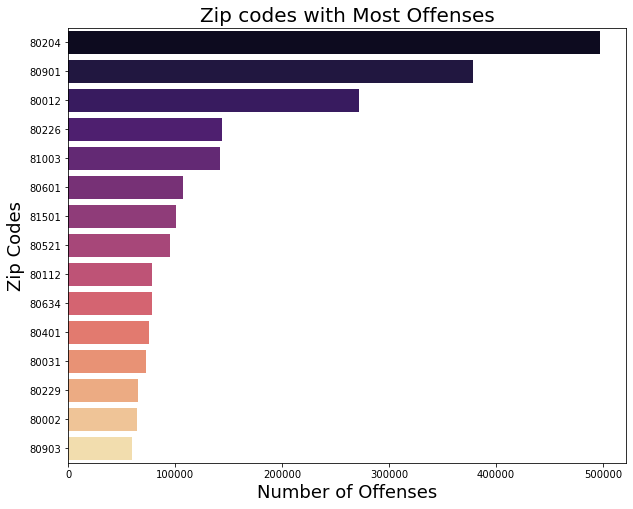

In [106]:
records_zip=df_full.icpsr_zip.value_counts()[:15]
zips=df_full.icpsr_zip.value_counts()[:15].index

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(records_zip, zips, palette='magma',ax=ax)
ax.set_ylabel('Zip Codes', fontsize=18);
ax.set_xlabel('Number of Offenses', fontsize=18);
ax.set_title('Zip codes with Most Offenses', fontsize=20)

Text(0.5, 1.0, 'Counties with Most Offenses')

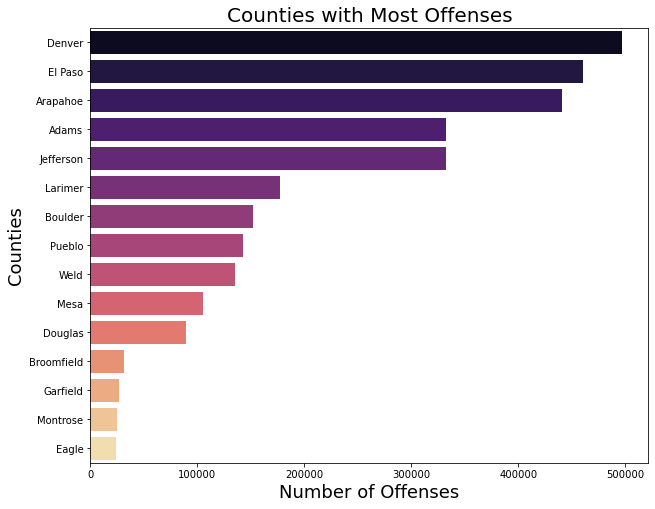

In [107]:
records_county=df_full.primary_county.value_counts()[:15]
counties=df_full.primary_county.value_counts()[:15].index

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(records_county, counties, palette='magma',ax=ax)
ax.set_ylabel('Counties', fontsize=18);
ax.set_xlabel('Number of Offenses', fontsize=18);
ax.set_title('Counties with Most Offenses', fontsize=20)

<ipython-input-108-ce4125cba4c3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


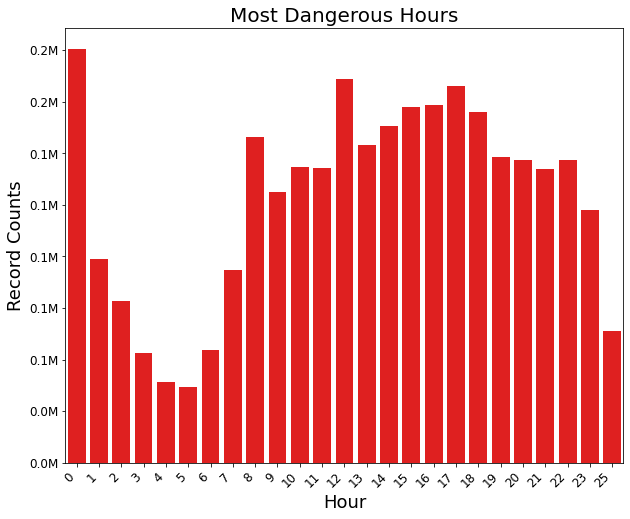

In [108]:
fig, ax = plt.subplots(figsize=(10,8))
g=sns.countplot(x='incident_hour', data=df_full, ax=ax,color='#ff0000',
              order=[0,1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25])
ax.set_title('Most Dangerous Hours', fontsize=20);
ax.set_ylabel('Record Counts', fontsize=18);
ax.set_xlabel('Hour', fontsize=18);
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, ha='right',fontsize=12)
ax.set_yticklabels(ylabels)
ax.tick_params(labelsize=12)

### Setting up the DataFrame to continue with Time-Series analysis

In [109]:
# Setting up timestamp index
df_full.set_index('timestamp', drop=True, inplace=True)

In [110]:
df_full.head()

,offense_id,incident_id,location_name,offense_name,crime_against,offense_category_name,agency_id,incident_hour,primary_county,icpsr_zip,bias_name,weapon
timestamp,,,,,,,,,,,,
2009-01-05,53563151,51264520,Residence/Home,Aggravated Assault,Person,Assault Offenses,1971,22,Kit Carson,80807,None,Non-automatic firearm
2009-01-13,53563402,51264521,Residence/Home,Theft From Motor Vehicle,Property,Larceny/Theft Offenses,1971,25,Kit Carson,80807,None,NA
2009-01-17,53558278,51264523,School/College,Drug/Narcotic Violations,Society,Drug/Narcotic Offenses,1971,19,Kit Carson,80807,None,NA
2009-01-17,53558279,51264523,School/College,Drug Equipment Violations,Society,Drug/Narcotic Offenses,1971,19,Kit Carson,80807,None,NA
2009-01-20,53563403,51264524,Other/Unknown,Impersonation,Property,Fraud Offenses,1971,25,Kit Carson,80807,None,NA


In [111]:
df_=df = df_full.groupby('offense_category_name')['offense_id'].nunique().sort_values(ascending=False)
df_

offense_category_name
Larceny/Theft Offenses                      1087217
Destruction/Damage/Vandalism of Property     496537
Assault Offenses                             413349
Drug/Narcotic Offenses                       317007
Burglary/Breaking & Entering                 246943
Fraud Offenses                               210473
Motor Vehicle Theft                          167666
Sex Offenses                                  59311
Counterfeiting/Forgery                        49302
Weapon Law Violations                         47347
Robbery                                       36538
Stolen Property Offenses                      18256
Kidnapping/Abduction                          17414
Arson                                         10059
Embezzlement                                   5158
Prostitution Offenses                          5089
Pornography/Obscene Material                   4995
Extortion/Blackmail                            2847
Animal Cruelty                            

In [112]:
pd.crosstab(index = df_full['offense_name'], columns = df_full['offense_category_name'])

offense_category_name,Animal Cruelty,Arson,Assault Offenses,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Destruction/Damage/Vandalism of Property,Drug/Narcotic Offenses,Embezzlement,Extortion/Blackmail,...,Human Trafficking,Kidnapping/Abduction,Larceny/Theft Offenses,Motor Vehicle Theft,Pornography/Obscene Material,Prostitution Offenses,Robbery,Sex Offenses,Stolen Property Offenses,Weapon Law Violations
offense_name,,,,,,,,,,,,,,,,,,,,,
Aggravated Assault,0,0,97681,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
All Other Larceny,0,0,0,0,0,0,0,0,0,0,...,0,0,365145,0,0,0,0,0,0,0
Animal Cruelty,2137,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arson,0,10059,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Assisting or Promoting Prostitution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1249,0,0,0,0
Betting/Wagering,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bribery,0,0,0,1219,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Burglary/Breaking & Entering,0,0,0,0,246943,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Counterfeiting/Forgery,0,0,0,0,0,49302,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# Creating a time-series
ts=df_full.resample('D').count()['offense_id']

### Exploring time-series plots

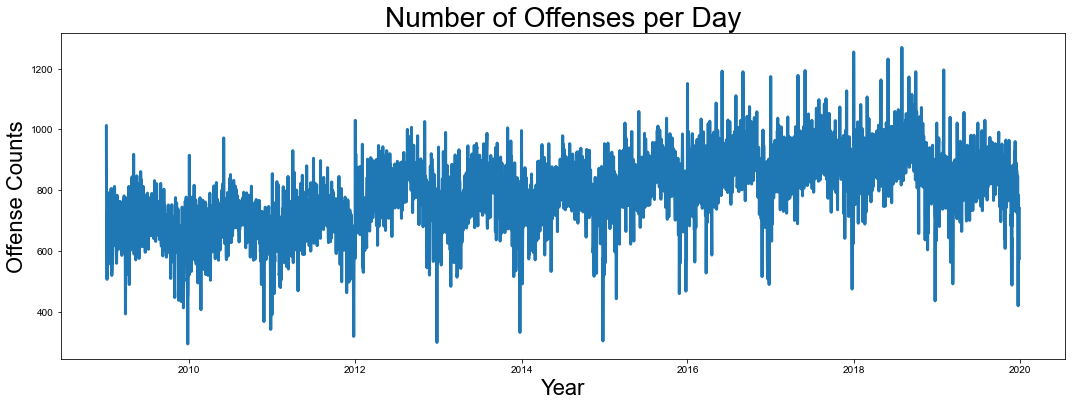

In [114]:
fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')
ax.plot(ts.index, ts.values)
ax.set_title('Number of Offenses per Day', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);

In [115]:
ts_weekly=ts.resample('W').mean()

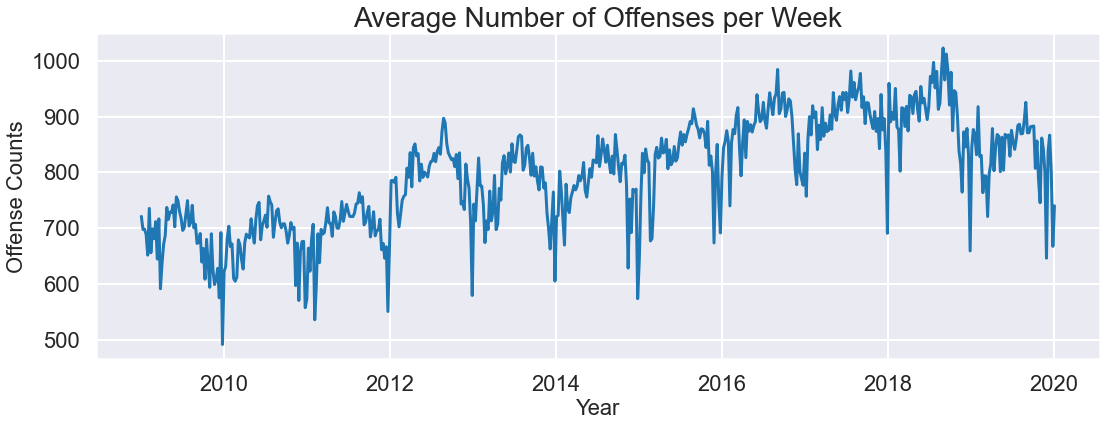

In [116]:
fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')
ax.plot(ts_weekly.index, ts_weekly.values)
ax.set_title('Average Number of Offenses per Week', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);

In [117]:
ts_ma=ts_weekly.rolling(52).mean()

In [118]:
ts_ewm=ts_weekly.ewm(span=52).mean()

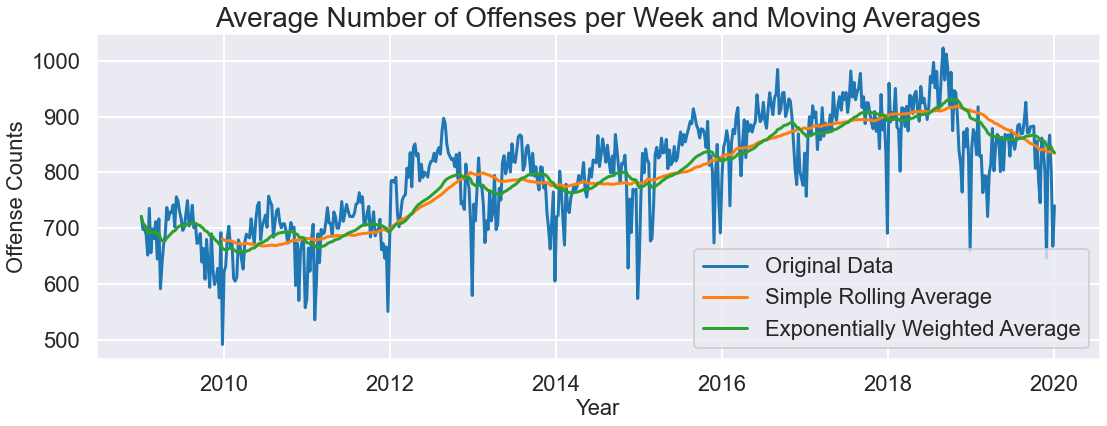

In [119]:
fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')
ax.plot(ts_weekly.index, ts_weekly.values, label='Original Data')
ax.plot(ts_ma.index,ts_ma.values, label='Simple Rolling Average')
ax.plot(ts_ewm.index,ts_ewm.values, label='Exponentially Weighted Average')
ax.set_title('Average Number of Offenses per Week and Moving Averages', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
plt.legend();

<br><br><span style="font-size:1.2em;">EWA displays a clear upward trend with a seasonality while SRA does not pick up the seasonal fluctuation tendency. The seasonality is quite pronounced and is of an additive nature. The problematic range of dates is a period from the late 2018 till the end of 2019 when the trend changes to a downward trend. Unfortunately, cutting off a test set with the latest dates will make it impossible to predict the overall trend correctly.</span><br><br>
    
    

<Figure size 640x480 with 0 Axes>

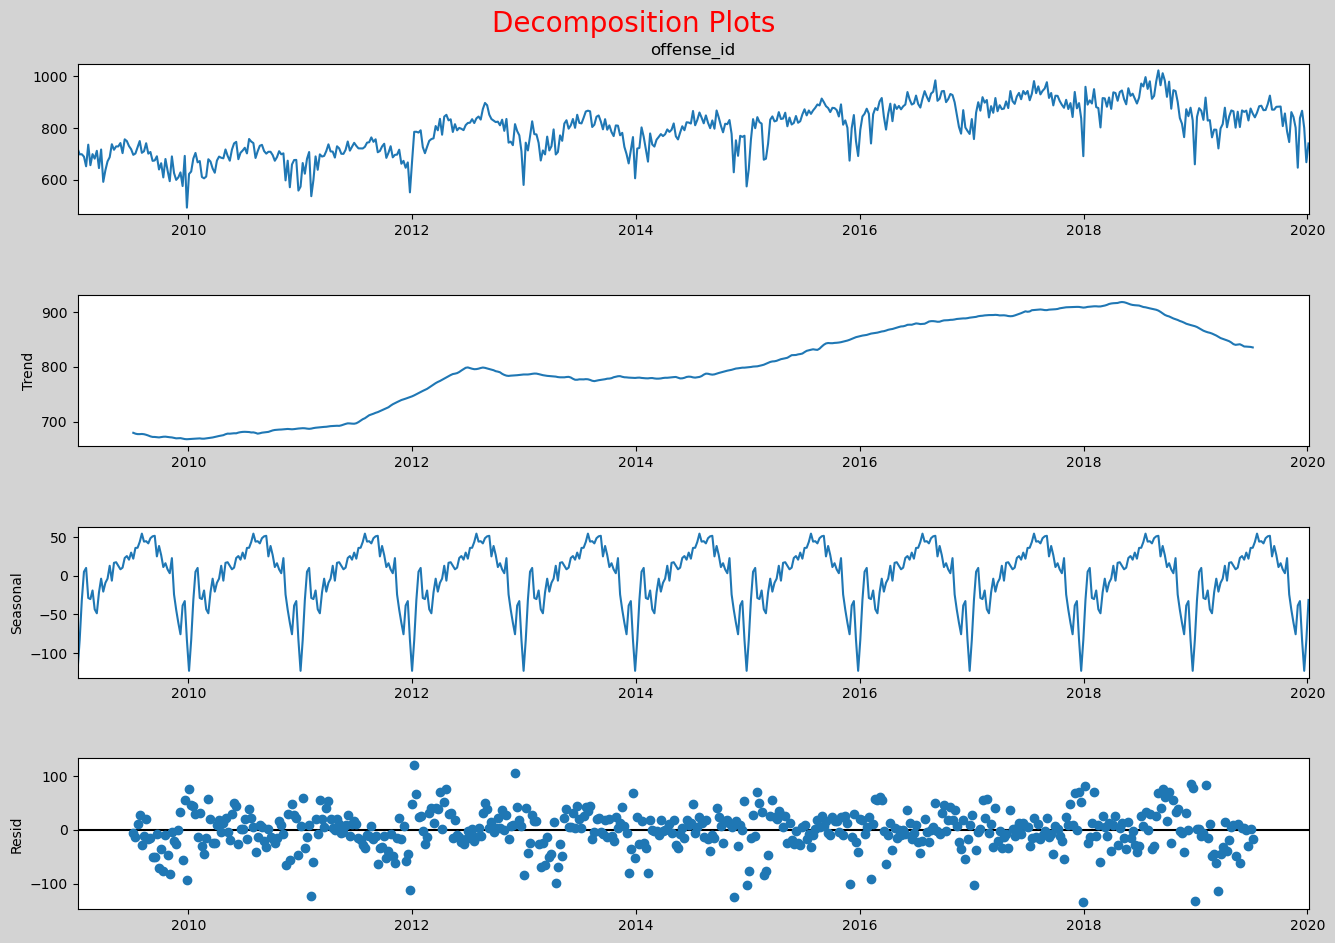

In [120]:
decomposing(ts_weekly)

<br><br><span style="font-size:1.2em;"><b>The time series displays a clear trend along with seasonal fluctuations. Seasonality is comparable with the overall trend values (>10%)</b></span>.<br><br>


### Testing for Stationarity

*********Dickey-Fuller test results*****************

Critival value = -2.7180233827058466
p-value = 0.0709710266829753
Number of lags = 13
Number of observations = 561
Critical values: 

Critical value at 1%: -3.442060292264578
Critical value at 5%: -2.866705729876777
Critical value at 10%: -2.569521171354946


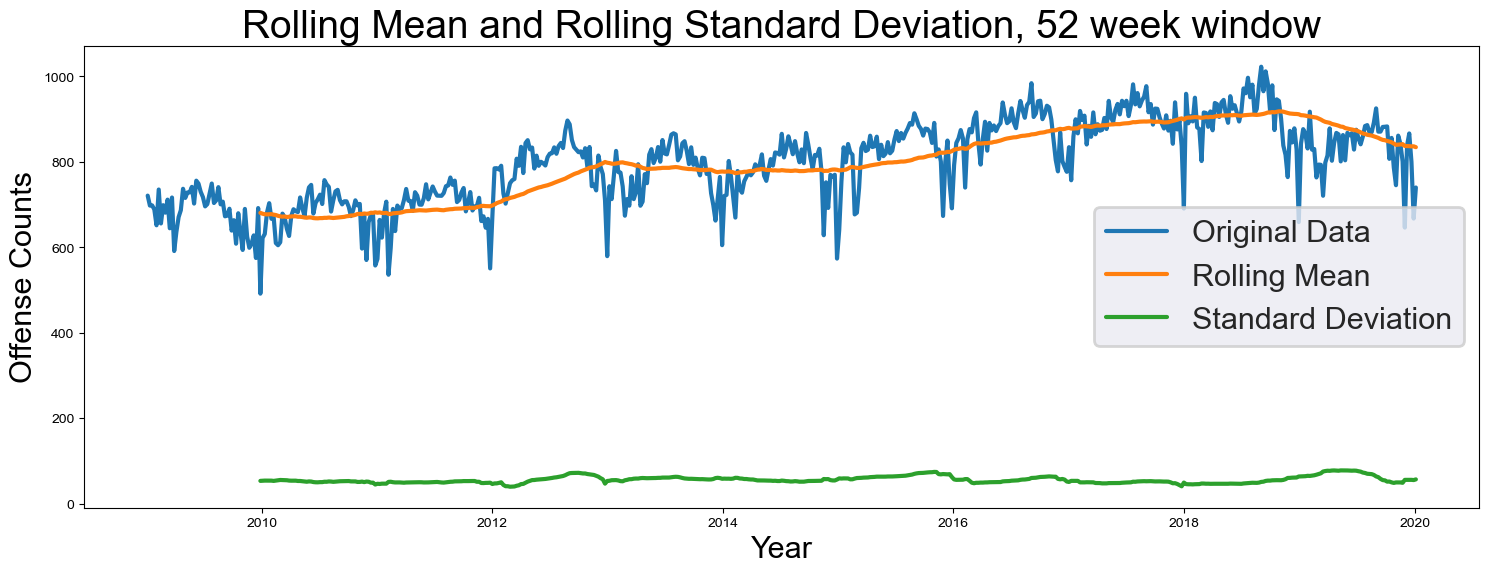

In [121]:
check_stationarity(ts_weekly, 52,'Original Data')

<br><br><span style="font-size:1.2em;">The time-series is **not stationary**, p-value is 0.07 (>0.05). Since critical value -2.72 > -3.44, -2.87 (t-values at 1% and 5% confidence intervals), null hypothesis cannot be rejected. The stationarization is needed.</span><br><br>


 

*********Dickey-Fuller test results*****************

Critival value = -7.02376739289635
p-value = 6.442785954458934e-10
Number of lags = 12
Number of observations = 561
Critical values: 

Critical value at 1%: -3.442060292264578
Critical value at 5%: -2.866705729876777
Critical value at 10%: -2.569521171354946


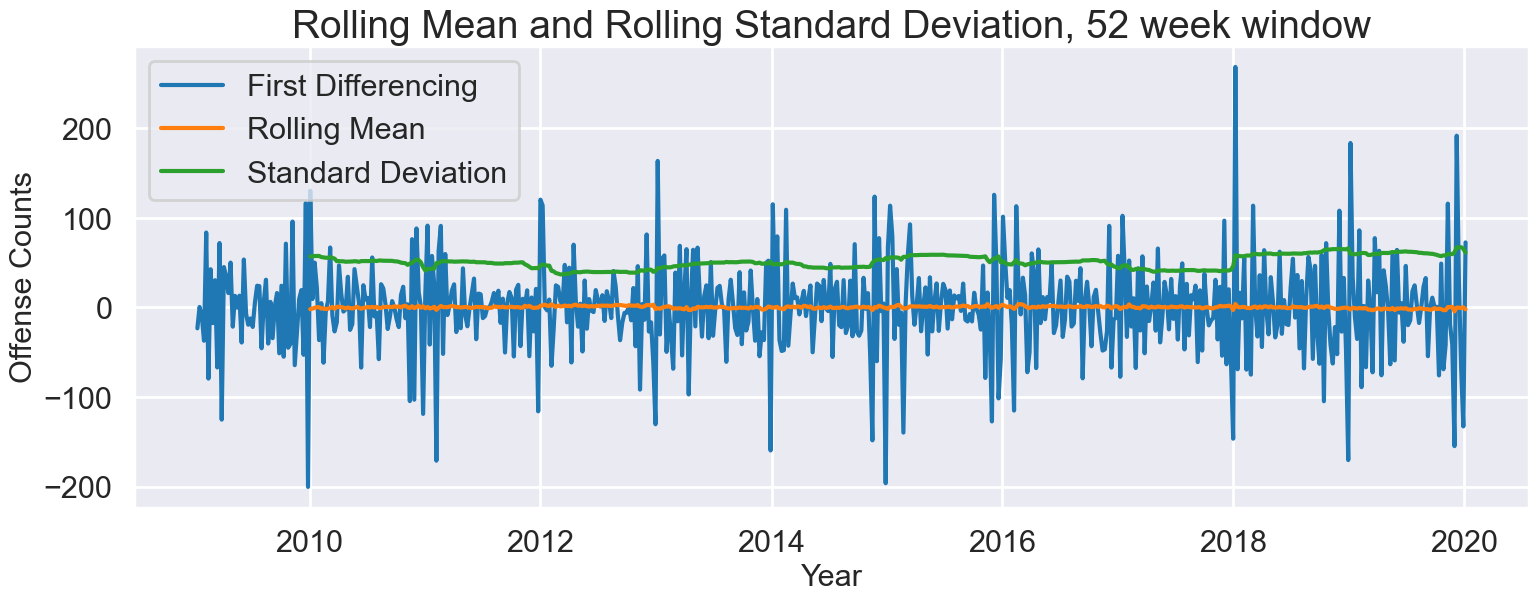

In [122]:
ts_diff1=ts_weekly.diff().dropna()
check_stationarity(ts_diff1, 52, 'First Differencing')

<br><br><span style="font-size:1.2em;">The first differenceing time-series is **stationary**, p-value is 6.443e-10 (well below 0.05). Also the critical value -7.02 < -3.44,-2.87  (t-values at 1% and 5% confidence intervals); null hypothesis is rejected.</span><br><br>

<Figure size 640x480 with 0 Axes>

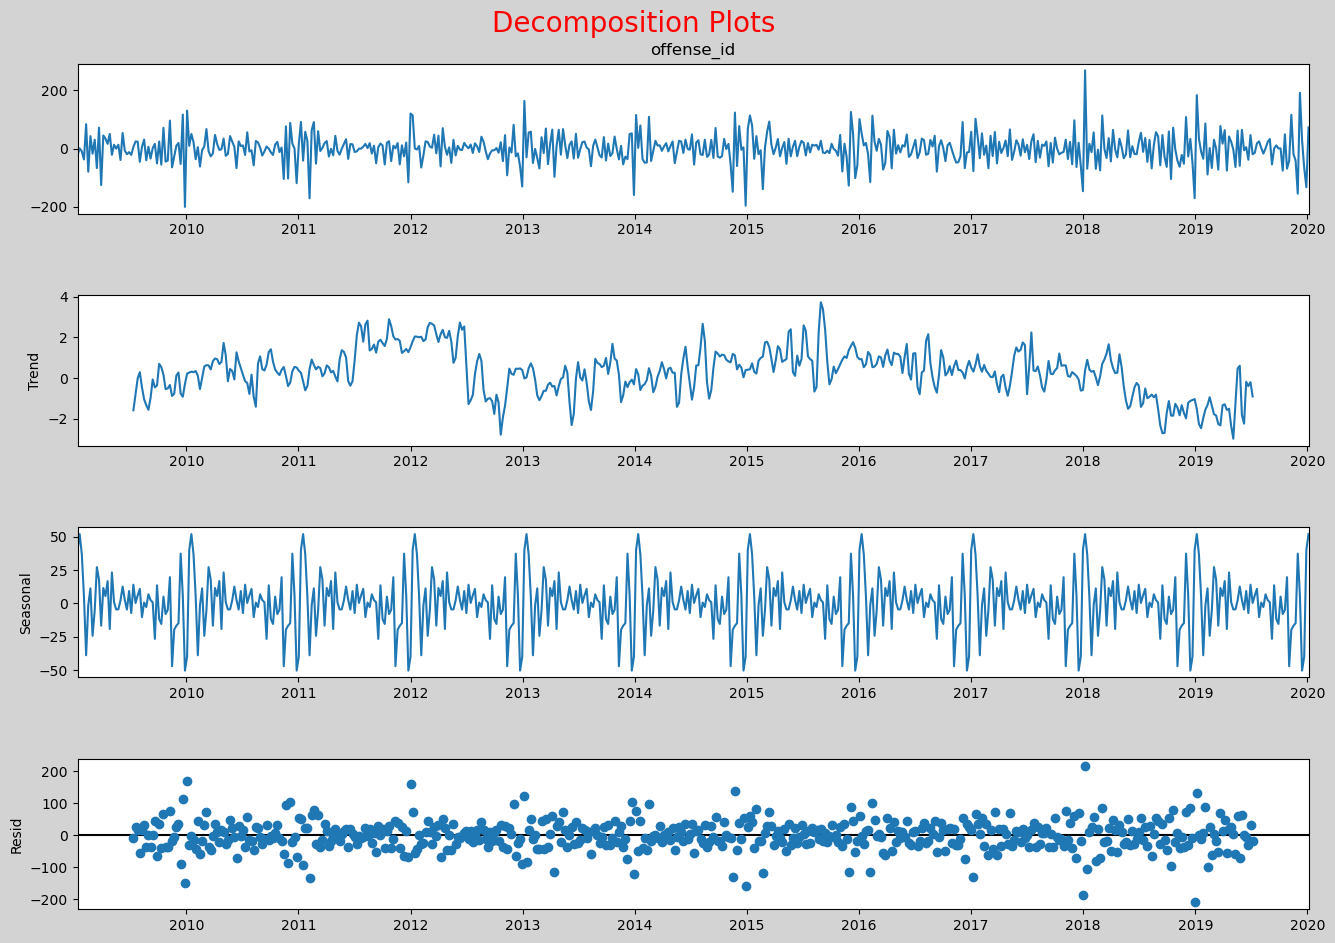

In [123]:
decomposing(ts_diff1)

<br><br><span style="font-size:1.2em;">The first differencing time-series decomposition displays clear seasonality.</span><br><br>

# MODEL

## General Crime Rate Modeling

### Splitting into a training and a test sets

<br><br><span style="font-size:1.2em;">I am cutting off a ~33% tail of my data to create a test set.</span><br>

Observations: 575 weeks
Training Observations: 380 weeks
Testing Observations: 195 weeks


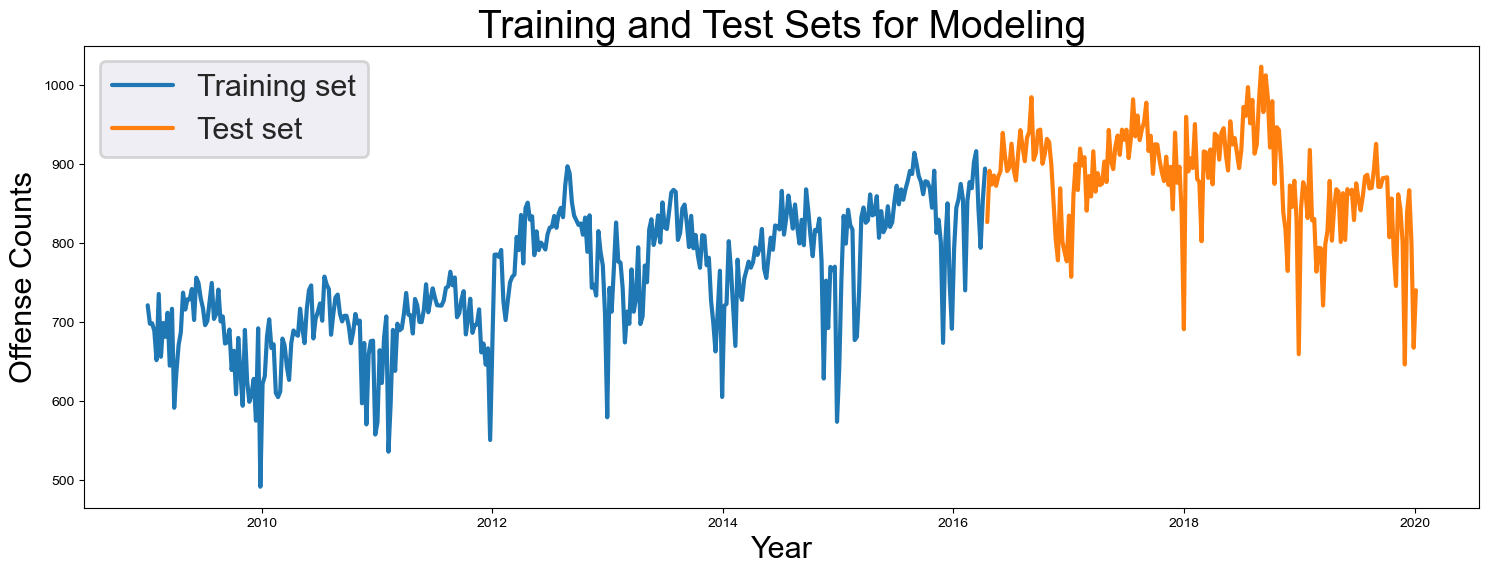

In [124]:
train_size = round(len(ts_weekly) * 0.66)
ts_train, ts_test = ts_weekly[:train_size], ts_weekly[train_size:]
print('Observations: %d weeks' % (len(ts_weekly)))
print('Training Observations: %d weeks' % (len(ts_train)))
print('Testing Observations: %d weeks' % (len(ts_test)))


fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')
ax.plot(ts_train.index, ts_train.values, label='Training set')
ax.plot(ts_test.index,ts_test.values, label='Test set')

ax.set_title('Training and Test Sets for Modeling', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
plt.legend();

### Partial Autocorrelation  and Autocorrelation Functions

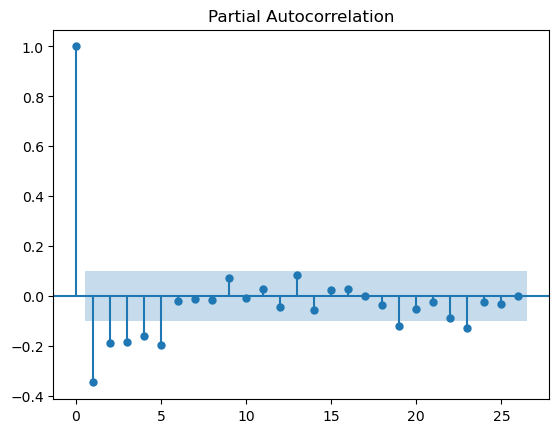

In [125]:
matplotlib.rc_file_defaults()
plot_pacf(ts_train.diff().dropna());

<br><br><span style="font-size:1.2em;">Partial autocorrelation function of the first ts differencing indicates the importance of the first 5 lags.</span><br><br>

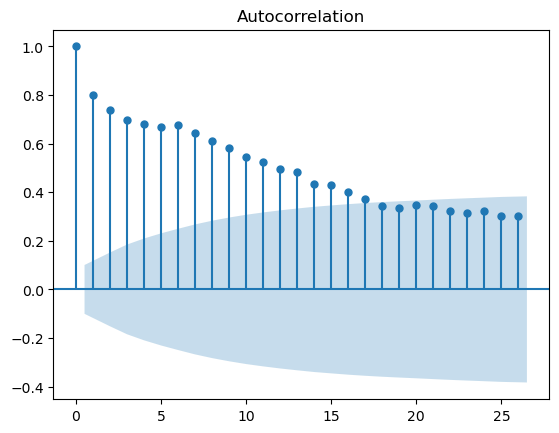

In [126]:
matplotlib.rc_file_defaults()
plot_acf(ts_train);

<br><br><span style="font-size:1.2em;">The ACF shows a long persistent autocorrelation up to the 16th lag. That is a strong indicator that the differencing should be taken to stationarize the TS.</span><br><br>

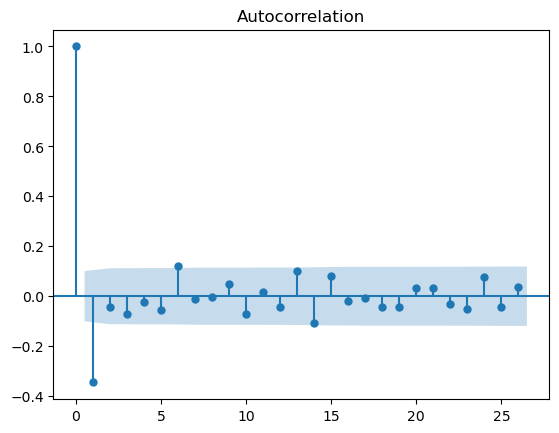

In [127]:
matplotlib.rc_file_defaults()
plot_acf(ts_train.diff().dropna());

<br><br><span style="font-size:1.2em;">The ACF of the differenced series displays the  sharp cut-off and the negative lag1 correlation and therefore one MA term could be added to the model.</span><br><br>

### Baseline Model

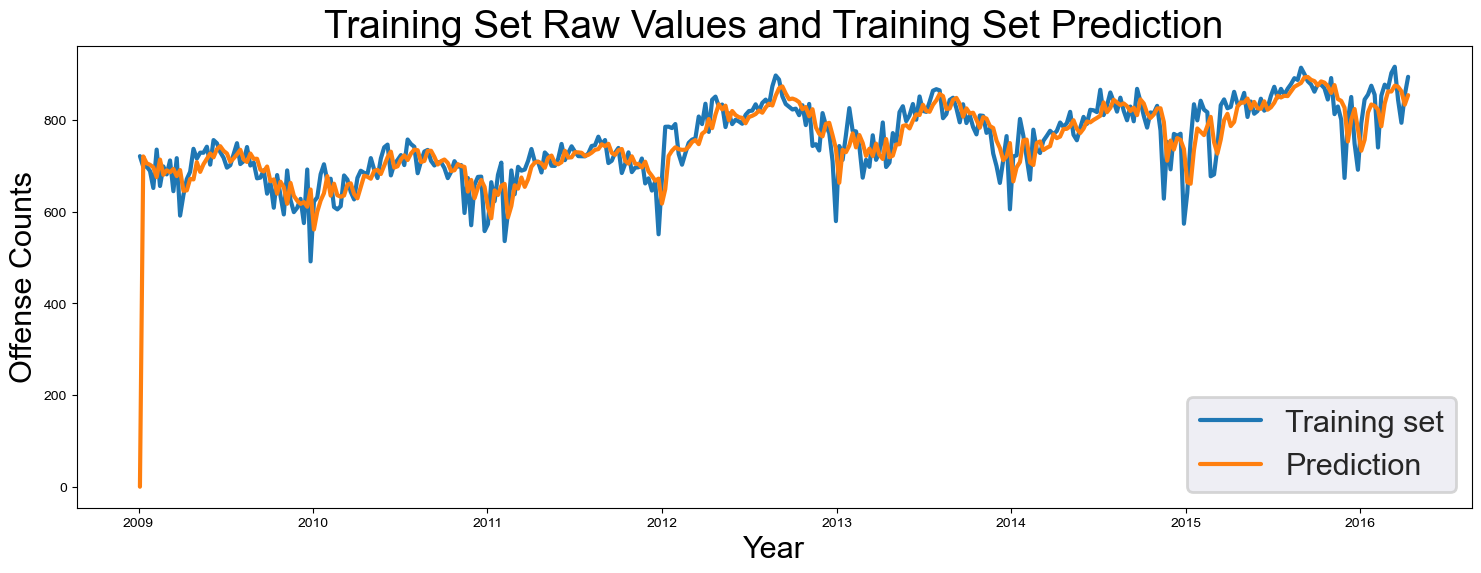

In [128]:
arima_1=ARIMA(ts_train, order=(5,1,0)).fit()
y_hat_train=arima_1.predict(typ='levels')

fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')
ax.plot(ts_train.index, ts_train.values, label='Training set')
ax.plot(y_hat_train.index, y_hat_train.values, label='Prediction')

ax.set_title('Training Set Raw Values and Training Set Prediction', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
plt.legend();

In [129]:
print('***************************\n'+'AIC={}'.format((round(arima_1.aic)))+'\n***************************')


***************************
AIC=3945
***************************


##### Testing the model

RMSE of the Baseline model is 64.06


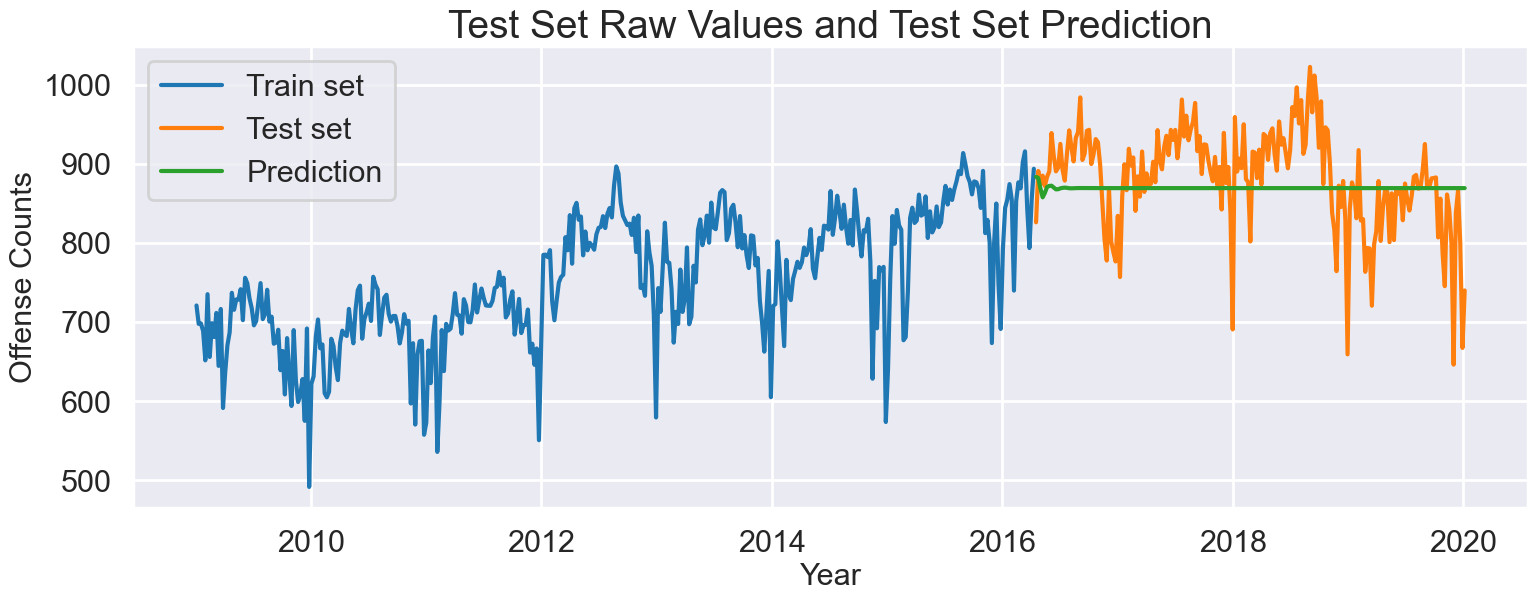

In [130]:
y_hat_test=arima_1.predict(start=ts_test.index[0], end=ts_test.index[-1], typ='levels')


rmse = np.sqrt(mean_squared_error(ts_test, y_hat_test))
print('RMSE of the Baseline model is {}'.format(round(rmse,2)))

fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')
ax.plot(ts_train.index, ts_train.values, label='Train set')
ax.plot(ts_test.index, ts_test.values, label='Test set')
ax.plot(y_hat_test.index, y_hat_test.values, label='Prediction')


ax.set_title('Test Set Raw Values and Test Set Prediction', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
plt.legend();

<br><br><span style="font-size:1.2em; background:lightblue">The ARIMA model above is our Baseline model</span><br><br>


### SARIMAX models

#### No exogenous regressors

<br><br><span style="font-size:1.2em;">I tried several combinations of pdq/PDQs and it seems that the most appropriate tryout ranges for MA terms and for AR terms in both trend and seasonal parts of the models are 0-1 and 4-5 respectively.</span><br><br>



In [131]:
p=range(4,6)
q=range(0,2)
pdq=list(itertools.product(p,[1],q))

P=range(4,6)
Q=range(0,2)
seasonal_pdq=[(x[0], x[1], x[2], 52) for x in list(itertools.product(P,[1],Q))]

for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX combination: {}x{}'.format(i,s))

SARIMAX combination: (4, 1, 0)x(4, 1, 0, 52)
SARIMAX combination: (4, 1, 0)x(4, 1, 1, 52)
SARIMAX combination: (4, 1, 0)x(5, 1, 0, 52)
SARIMAX combination: (4, 1, 0)x(5, 1, 1, 52)
SARIMAX combination: (4, 1, 1)x(4, 1, 0, 52)
SARIMAX combination: (4, 1, 1)x(4, 1, 1, 52)
SARIMAX combination: (4, 1, 1)x(5, 1, 0, 52)
SARIMAX combination: (4, 1, 1)x(5, 1, 1, 52)
SARIMAX combination: (5, 1, 0)x(4, 1, 0, 52)
SARIMAX combination: (5, 1, 0)x(4, 1, 1, 52)
SARIMAX combination: (5, 1, 0)x(5, 1, 0, 52)
SARIMAX combination: (5, 1, 0)x(5, 1, 1, 52)
SARIMAX combination: (5, 1, 1)x(4, 1, 0, 52)
SARIMAX combination: (5, 1, 1)x(4, 1, 1, 52)
SARIMAX combination: (5, 1, 1)x(5, 1, 0, 52)
SARIMAX combination: (5, 1, 1)x(5, 1, 1, 52)


In [132]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             sarimax_mod=SARIMAX(ts_train,
#                                 order=param,
#                                 seasonal_order=param_seasonal,
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
#             results=sarimax_mod.fit()
#             print('ARIMA{}x{}-AIC:{}:'.format(param, param_seasonal,results.aic))
#         except:
#             print('Error!')
#             continue

<br><br><span style="font-size:1.2em;">**ARIMA(5, 1, 1)x(5, 1, 0, 52)-AIC:635.36:** is our best model. it took 2 hours and 22 mniutes to complete this search. therefore I am commenting out this snippet.</span><br><br>



In [133]:
# sarimax_mod1=SARIMAX(ts_train,
#                     order=(5, 1, 1),
#                     seasonal_order=(5, 1, 0, 52),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False).fit()


<br><br><span style="font-size:1.2em;">The model above took 15 minutes to fit, therefore it is pickled to be used forward.</span><br><br>



In [134]:
# with open('data/pickled_models/sarimax_mod1.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod1, f)

In [135]:
with open('data/pickled_models/sarimax_mod1.pickle', 'rb') as f:
    sarimax_mod1=pickle.load(f)

In [136]:
print('***************************\n'+'AIC={}'.format((round(sarimax_mod1.aic)))+'\n***************************')


***************************
AIC=635
***************************


##### Testing

RMSE of the SARIMAX model is 85.65


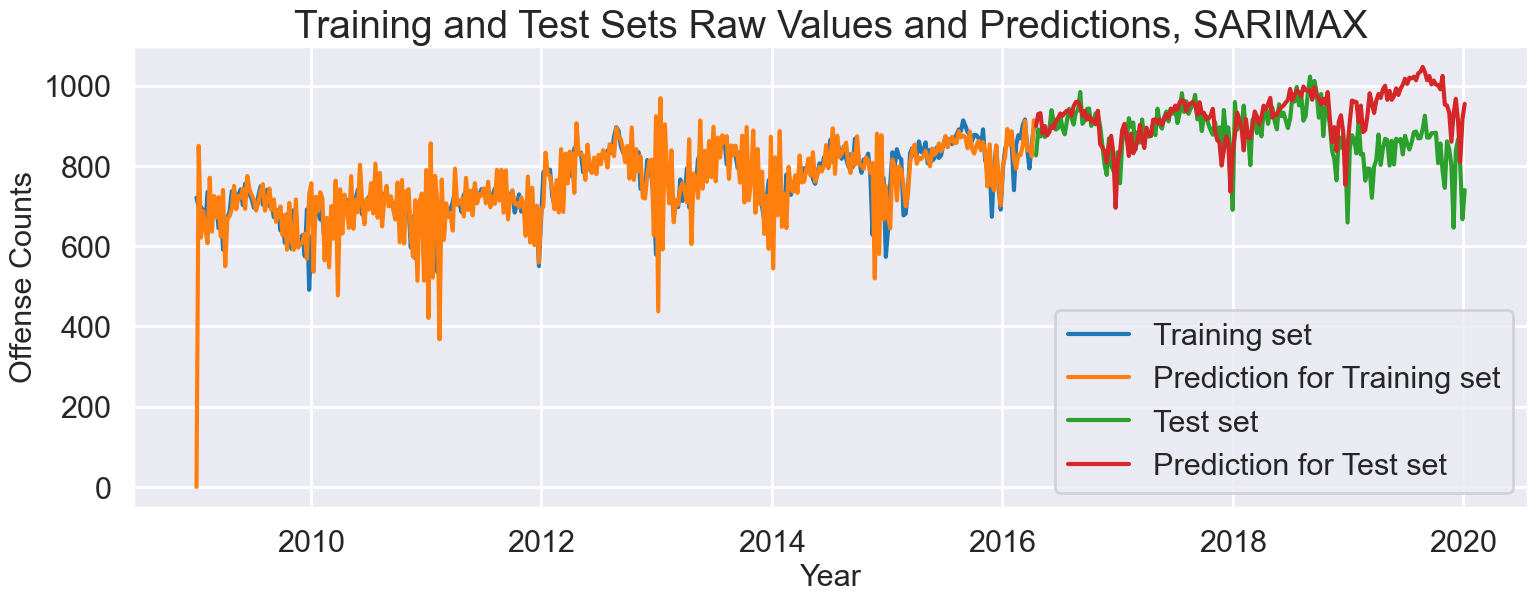

In [137]:
y_hat_train=sarimax_mod1.predict(typ='levels')
y_hat_test=sarimax_mod1.predict(start=ts_test.index[0], end=ts_test.index[-1], typ='levels')

rmse = np.sqrt(mean_squared_error(ts_test, y_hat_test))
print('RMSE of the SARIMAX model is {}'.format(round(rmse,2)))

fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')

ax.plot(ts_train.index, ts_train.values, label='Training set')
ax.plot(y_hat_train.index, y_hat_train.values, label='Prediction for Training set')
ax.plot(ts_test.index, ts_test.values, label='Test set')
ax.plot(y_hat_test.index, y_hat_test.values, label='Prediction for Test set')

ax.set_title('Training and Test Sets Raw Values and Predictions, SARIMAX', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
#ax.set_xlim('2016','2020');
plt.legend();

<br><br><span style="font-size:1.2em;">As expected the model failed to predict the latest downward swing correctly due to the fact that training data did not have this information at all. However, the model predicted the general trend in the previous two years pretty well. The RMSE value is worse than the RMSE for the Baseline model just because the predicted values of the Baseline model are a mean value over the test period.</span><br><br>

#### Adding US holidays as exogenous regressors

<br><span style="font-size:1.2em;">I will add holiday exogenous variables as an additional argument to the SARIMAX model to see if it helps improving the performance.</span><br><br>

In [138]:
# Creating an exogenous TS with US holidays

hlds= pd.date_range(start='1/1/2009',  end='12/31/2019',freq='D')

us_holidays=[]
years_=range(2009,2020)
for year in years_:
    for holiday in holidays.UnitedStates(years=year).items():
        us_holidays.append(holiday[0])

holiday_column=[]
for date_ in hlds:
    if date_ in us_holidays:
        holiday_column.append(1)
    else:
        holiday_column.append(0)

df_holidays=pd.DataFrame(hlds)
df_holidays['Holiday']=holiday_column
df_holidays=df_holidays.rename(columns={0:'Timestamp'})
df_holidays=df_holidays.set_index('Timestamp')
ts_holidays_weekly=df_holidays.resample('W').sum()


In [139]:
# Spliting exogenous TS into the training and the test parts

train_size_holidays = round(len(ts_holidays_weekly) * 0.66)
ts_train_holiday, ts_test_holiday = ts_holidays_weekly[:train_size], ts_holidays_weekly[train_size:]

In [140]:
# sarimax_mod2=SARIMAX(ts_train, exog=ts_train_holiday,
#                     order=(5, 1, 1),
#                     seasonal_order=(5, 1, 0, 52),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False).fit()


<br><br><span style="font-size:1.2em;">The model above took 18.5 minutes to fit, therefore it is pickled to be used forward.</span><br><br>

In [141]:
# with open('data/pickled_models/sarimax_mod2.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod2, f)

In [142]:
with open('data/pickled_models/sarimax_mod2.pickle', 'rb') as f:
    sarimax_mod2=pickle.load(f)

In [143]:
print('***************************\n'+'AIC={}'.format((round(sarimax_mod2.aic)))+'\n***************************')


***************************
AIC=639
***************************


<span style="font-size:1.2em;">This model performed very slightly worse than the one without exogenous regressors in terms of AIC value.</span><br><br>

##### Testing

RMSE of the SARIMAX model (w US holidays) is 79.04


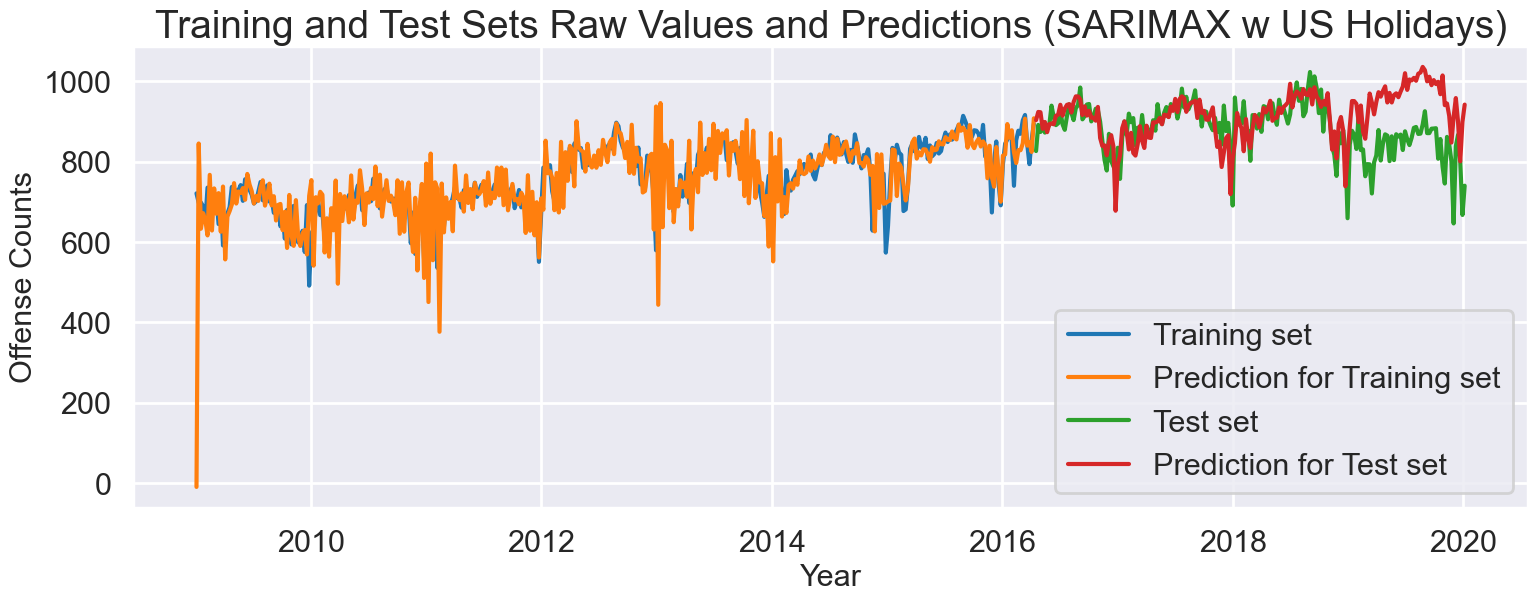

In [144]:
y_hat_train=sarimax_mod2.predict(typ='levels')
y_hat_test=sarimax_mod2.predict(start=ts_test.index[0], end=ts_test.index[-1], exog=ts_test_holiday,typ='levels')

rmse = np.sqrt(mean_squared_error(ts_test, y_hat_test))
print('RMSE of the SARIMAX model (w US holidays) is {}'.format(round(rmse,2)))

fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')

ax.plot(ts_train.index, ts_train.values, label='Training set')
ax.plot(y_hat_train.index, y_hat_train.values, label='Prediction for Training set')
ax.plot(ts_test.index, ts_test.values, label='Test set')
ax.plot(y_hat_test.index, y_hat_test.values, label='Prediction for Test set')

ax.set_title('Training and Test Sets Raw Values and Predictions (SARIMAX w US Holidays)', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
#ax.set_xlim('2016','2020');
plt.legend();

<span style="font-size:1.2em;">The RMSE value of this model is better than the one from the model w/o US holidays regressors.</span><br><br>

### Forecasting

#### SARIMAX w/o US holidays

###### ACF and PACF

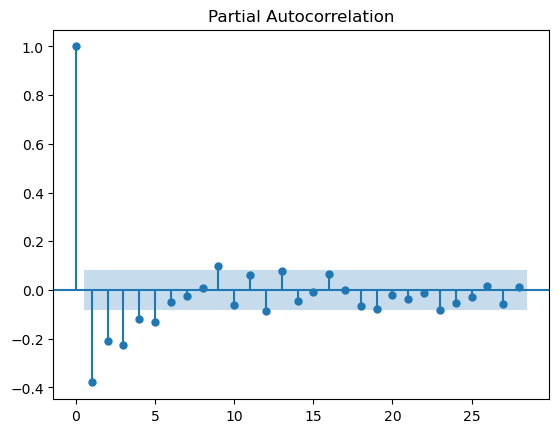

In [145]:
matplotlib.rc_file_defaults()
plot_pacf(ts_weekly.diff().dropna());

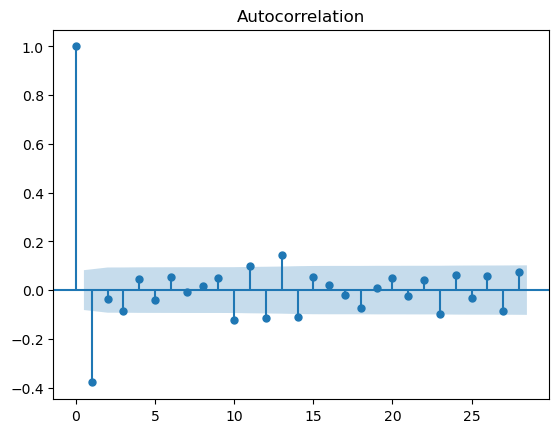

In [146]:
matplotlib.rc_file_defaults()
plot_acf(ts_weekly.diff().dropna());

<br><br><span style="font-size:1.2em;">Based on PACF and ACF plots the same model would work best for the full dataset as well (not just the training subset).</span><br><br>



###### Fitting the model to the full dataset

In [147]:
# sarimax_mod1_for=SARIMAX(ts_weekly,
#                     order=(5, 1, 1),
#                     seasonal_order=(5, 1, 0, 52),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False).fit()

<br><br><span style="font-size:1.2em;">The model above took 9 minutes to fit, therefore it is pickled to be used forward.</span><br><br>



In [148]:
# with open('data/pickled_models/sarimax_mod1_for.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod1_for, f)

In [149]:
with open('data/pickled_models/sarimax_mod1_for.pickle', 'rb') as f:
    sarimax_mod1_for=pickle.load(f)

In [150]:
print('***************************\n'+'AIC={}'.format((round(sarimax_mod1_for.aic)))+'\n***************************')

***************************
AIC=2678
***************************


In [151]:
forecast=sarimax_mod1_for.forecast(steps=52)

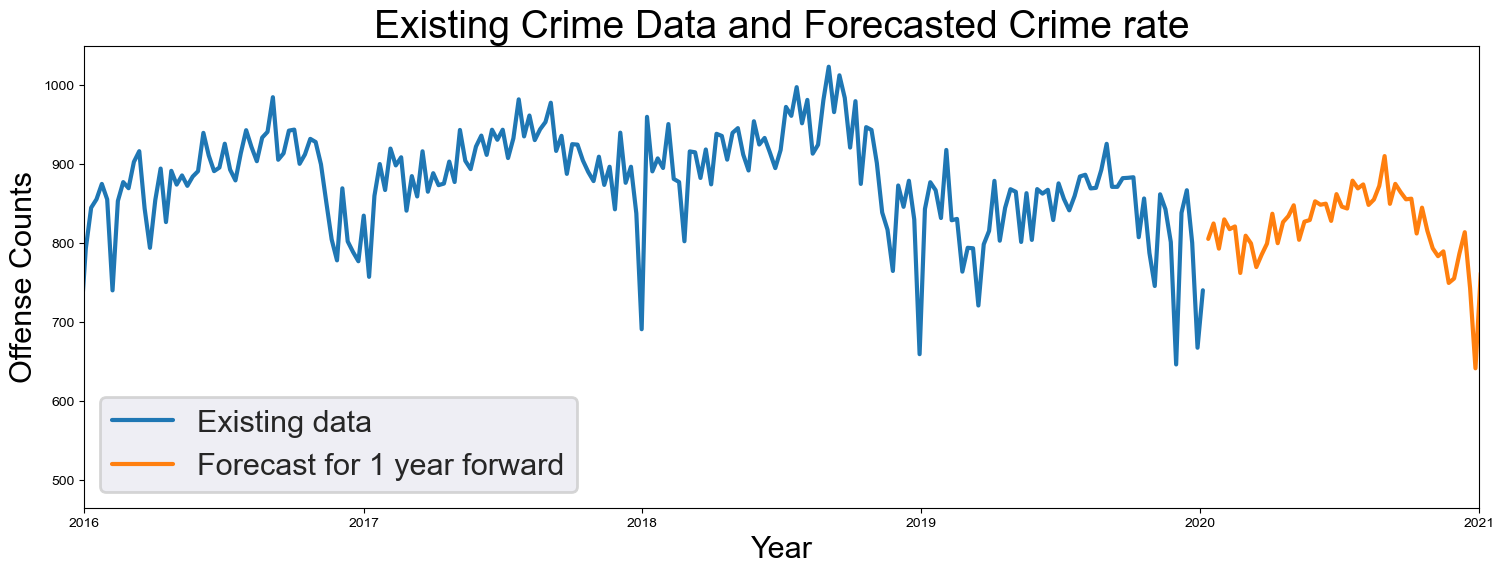

In [152]:
fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')

ax.plot(ts_weekly.index, ts_weekly.values, label='Existing data')
ax.plot(forecast.index, forecast.values, label='Forecast for 1 year forward')

ax.set_title('Existing Crime Data and Forecasted Crime rate', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
ax.set_xlim('2016','2021');

plt.legend();

#### SARIMAX with US holidays

###### Fitting the model to the full dataset with full US holiday schedule

In [153]:
# sarimax_mod2_for=SARIMAX(ts_weekly, exog=ts_holidays_weekly,
#                     order=(5, 1, 1),
#                     seasonal_order=(5, 1, 0, 52),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False).fit()

<br><br><span style="font-size:1.2em;">The fitting of the model took 23 minutes therefore I am saving it to a pickle file.</span><br><br>



In [154]:
# with open('data/pickled_models/sarimax_mod2_for.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod2_for, f)

In [155]:
with open('data/pickled_models/sarimax_mod2_for.pickle', 'rb') as f:
    sarimax_mod2_for=pickle.load(f)

In [156]:
print('***************************\n'+'AIC={}'.format((round(sarimax_mod2_for.aic)))+'\n***************************')


***************************
AIC=2674
***************************


In [157]:
# Creating a exogenous regressors TS for forecasting

hlds_for= pd.date_range(start='1/1/2020',  end='1/1/2021', freq='D')

us_holidays_for=[]
years_=range(2020,2021)
for year in years_:
    for holiday in holidays.UnitedStates(years=year).items():
        us_holidays_for.append(holiday[0])

holiday_column_for=[]
for date_ in hlds_for:
    if date_ in us_holidays_for:
        holiday_column_for.append(1)
    else:
        holiday_column_for.append(0)

df_holidays_for=pd.DataFrame(hlds_for)
df_holidays_for['Holiday']=holiday_column_for
df_holidays_for=df_holidays_for.rename(columns={0:'Timestamp'})
df_holidays_for=df_holidays_for.set_index('Timestamp')
ts_holidays_for_weekly=df_holidays_for.resample('W').sum()

In [158]:
# I am extending the period to 53 weeks to cover all the span of the US_holidays TS above (it includes 53 weeks)

forecast2=sarimax_mod2_for.forecast(steps=53, exog=ts_holidays_for_weekly)

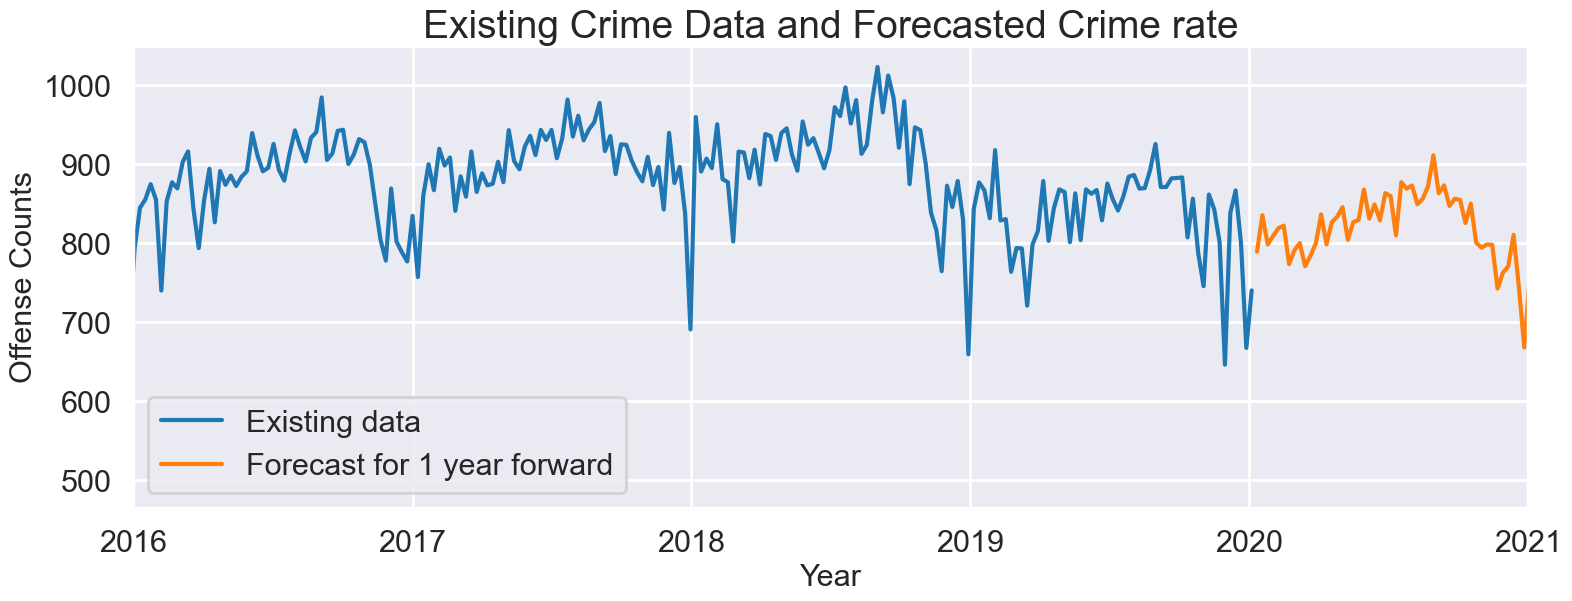

In [159]:
fig, ax = plt.subplots(figsize=(18,6))
sns.set_context('poster')
sns.set_style('darkgrid')

ax.plot(ts_weekly.index, ts_weekly.values, label='Existing data')
ax.plot(forecast2.index, forecast2.values, label='Forecast for 1 year forward')

ax.set_title('Existing Crime Data and Forecasted Crime rate', fontsize=28);
ax.set_ylabel('Offense Counts', fontsize=22);
ax.set_xlabel('Year', fontsize=22);
ax.set_xlim('2016','2021');

plt.legend();

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

# TO DO/FUTURE WORK

- 